In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

In [33]:
#cargar archivos
df_result = pd.read_csv("../results/fechas_11/df_20250501_to_20250515_M1_preproc.csv") #cambiar la direccion

#params
M=1
sub_dir='../results/fechas_2/' #cambiar la direccion

In [34]:
#agregar a nivel dia por empresa, esto es sumar h=1 hasta 23
# -------------------------------------------------------------------------
# Encontrar el termino  ∑_{h=0}^{23} E_{-it}[ Q_{ith} - pos_{ith} | s, p_{ht}=b_{it} ] )
# y el termino ( ∑_{h=0}^{23} E_{-it}[ ∂Q_{ith}/∂b_{it}    | s, p_{ht}=b_{it} ] )
# -------------------------------------------------------------------------

df_result['FechaHora'] = pd.to_datetime(df_result['FechaHora'], errors='coerce')
df_result['Fecha'] = df_result['FechaHora'].dt.date

df_grouped = (
    df_result.groupby(['Fecha', 'CodigoPlanta'], as_index=False)
      .agg(
          numerador=('EQpos', 'sum'),
          denominador=('EdQb', 'sum'),
          precio_d=('precio', 'first'),
          
      )
)


In [35]:
df_grouped

,Fecha,CodigoPlanta,numerador,denominador,precio_d
0,2025-05-01,2QEK,1.220520e+08,-451516.540006,102.64
1,2025-05-01,3DDT,5.147919e+07,-242603.695230,99.19
2,2025-05-01,3ENA,1.222288e+08,-433894.314052,849.04
3,2025-05-01,3HF5,5.486190e+07,-263976.625644,99.19
4,2025-05-01,3INX,5.479813e+07,-263976.625644,92.39
...,...,...,...,...,...
783,2025-05-15,TYP3,1.166444e+08,-265881.250157,96.39
784,2025-05-15,URA1,1.923815e+08,-267890.644675,103.39
785,2025-05-15,ZPA2,1.911006e+08,-267890.644675,373.39
786,2025-05-15,ZPA4,1.911006e+08,-267890.644675,359.39


In [36]:
#encontrar formula de costo marginal:
# -------------------------------------------------------------------------
#
#      φ_{it} = b_{it} +
#               ( ∑_{h=0}^{23} E_{-it}[ Q_{ith} - pos_{ith} | s, p_{ht}=b_{it} ] )
#               ----------------------------------------------------------------
#               ( ∑_{h=0}^{23} E_{-it}[ ∂Q_{ith}/∂b_{it}    | s, p_{ht}=b_{it} ] )
#
# -------------------------------------------------------------------------

# Evitar divisiones por cero
df_grouped['phi'] = df_grouped['precio_d'] + np.where(
    df_grouped['denominador'] != 0,
    df_grouped['numerador'] / df_grouped['denominador'],
    df_grouped['precio_d']     #si no hay markup entonces le toca que su bid sea su costo marginal sino no tiene sentido
)


In [43]:
df_grouped

,Fecha,CodigoPlanta,numerador,denominador,precio_d,phi
0,2025-05-01,2QEK,1.220520e+08,-451516.540006,102.64,-167.675691
1,2025-05-01,3DDT,5.147919e+07,-242603.695230,99.19,-113.004566
2,2025-05-01,3ENA,1.222288e+08,-433894.314052,849.04,567.338253
3,2025-05-01,3HF5,5.486190e+07,-263976.625644,99.19,-108.638645
4,2025-05-01,3INX,5.479813e+07,-263976.625644,92.39,-115.197053
...,...,...,...,...,...,...
783,2025-05-15,TYP3,1.166444e+08,-265881.250157,96.39,-342.318590
784,2025-05-15,URA1,1.923815e+08,-267890.644675,103.39,-614.744402
785,2025-05-15,ZPA2,1.911006e+08,-267890.644675,373.39,-339.962977
786,2025-05-15,ZPA4,1.911006e+08,-267890.644675,359.39,-353.962977


In [37]:
diff=df_grouped['precio_d']-df_grouped['phi']
diff.describe()

count      788.000000
mean      1452.759954
std       1514.334754
min        180.599694
25%        694.214454
50%        946.513235
75%       1507.592262
max      16274.893278
dtype: float64

In [38]:
print(diff[diff > 0])


0      270.315691
1      212.194566
2      281.701747
3      207.828645
4      207.587053
          ...    
783    438.708590
784    718.134402
785    713.352977
786    713.352977
787    713.352977
Length: 788, dtype: float64


## Graficar

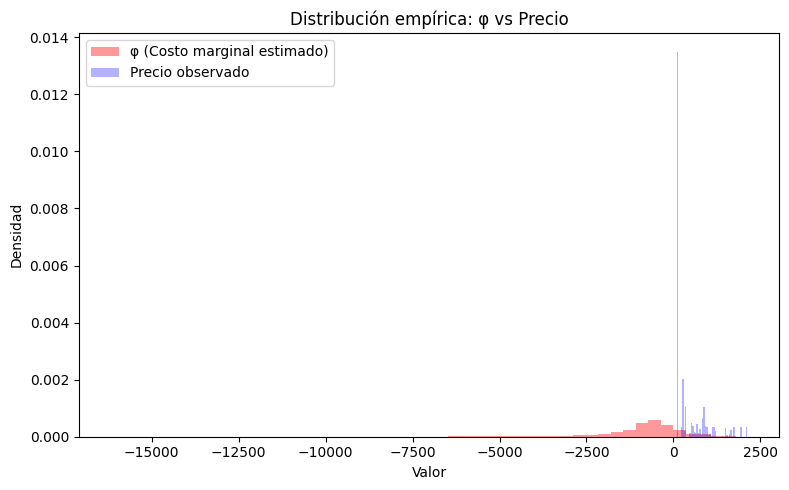

In [39]:
phi = pd.to_numeric(df_grouped['phi'], errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()
precio = pd.to_numeric(df_grouped['precio_d'], errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(8,5))
plt.hist(phi, bins=50, density=True, color="red", alpha=0.4, label="φ (Costo marginal estimado)")
plt.hist(precio, bins=50, density=True, color="blue", alpha=0.3, label="Precio observado")
plt.xlabel("Valor")
plt.ylabel("Densidad")
plt.title("Distribución empírica: φ vs Precio")
plt.legend()
plt.tight_layout()
plt.show()

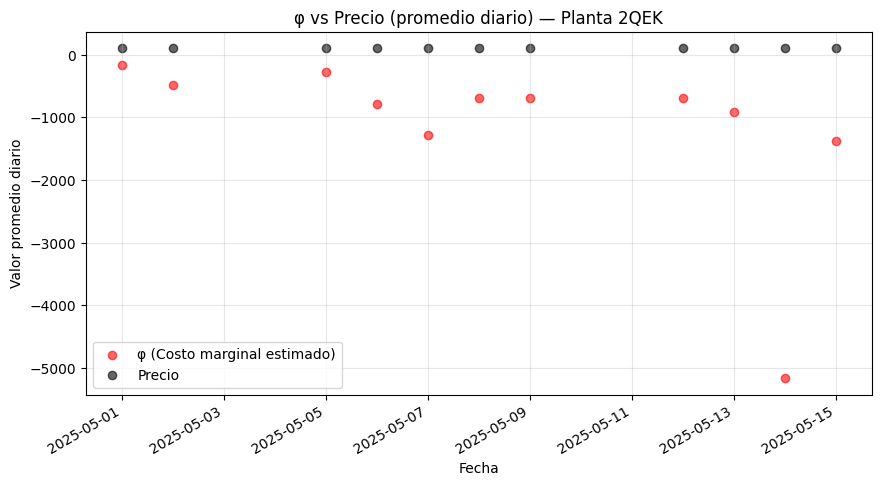

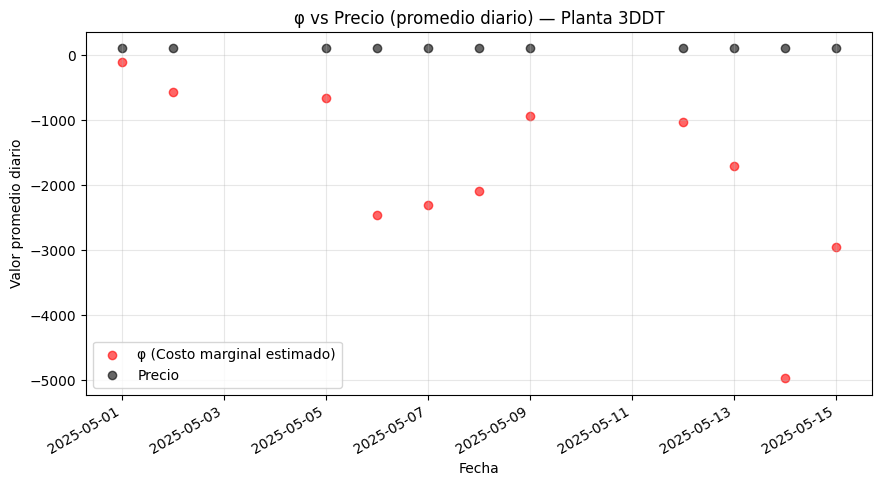

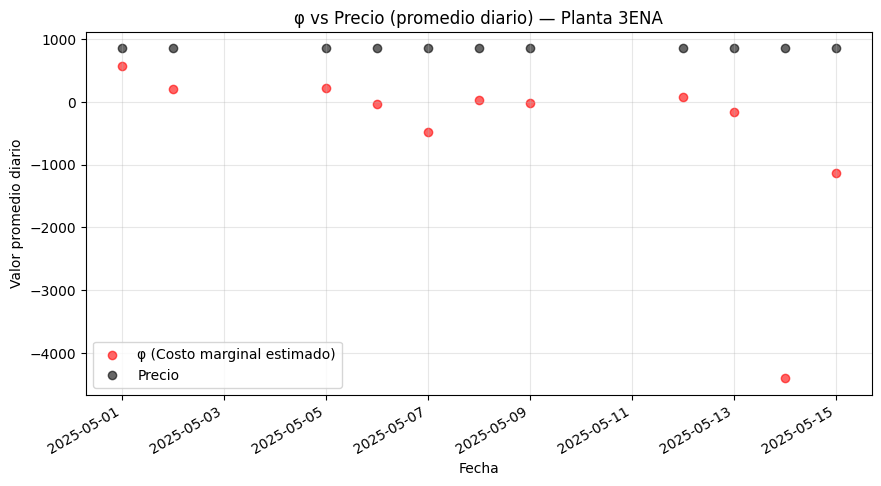

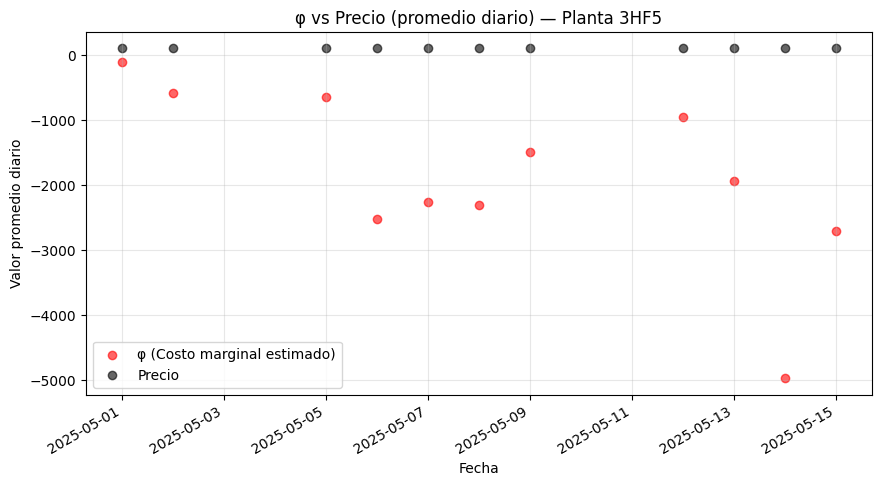

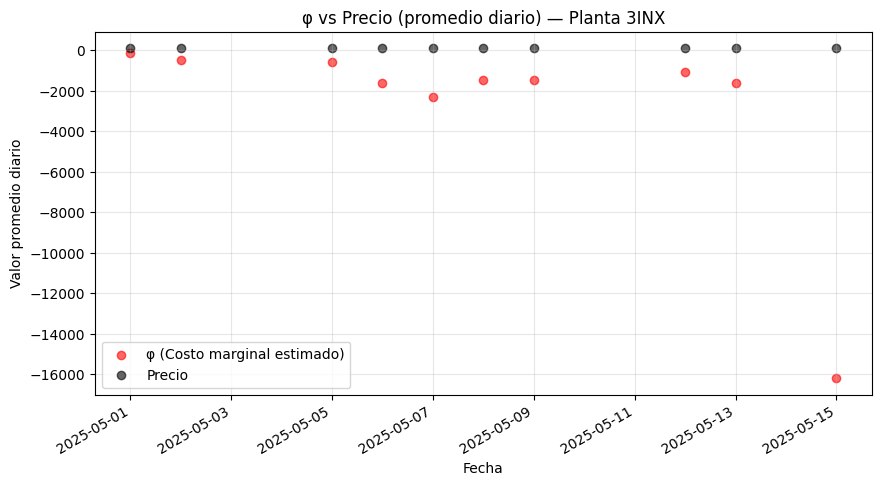

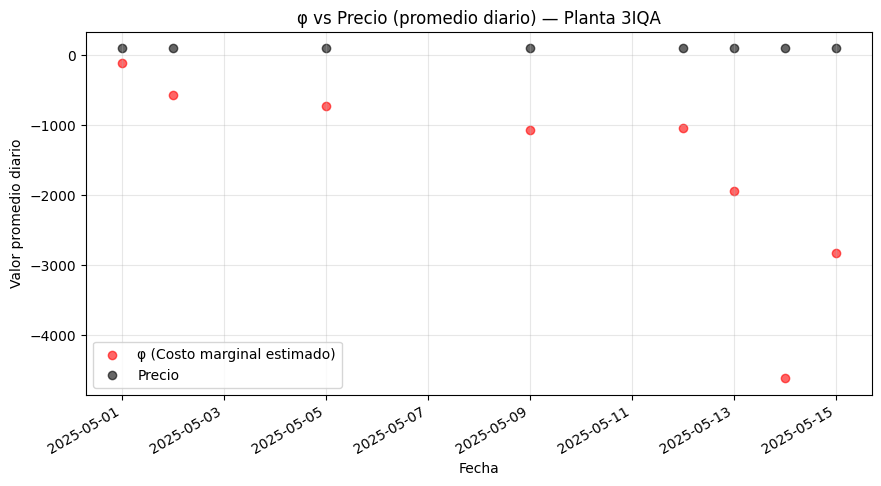

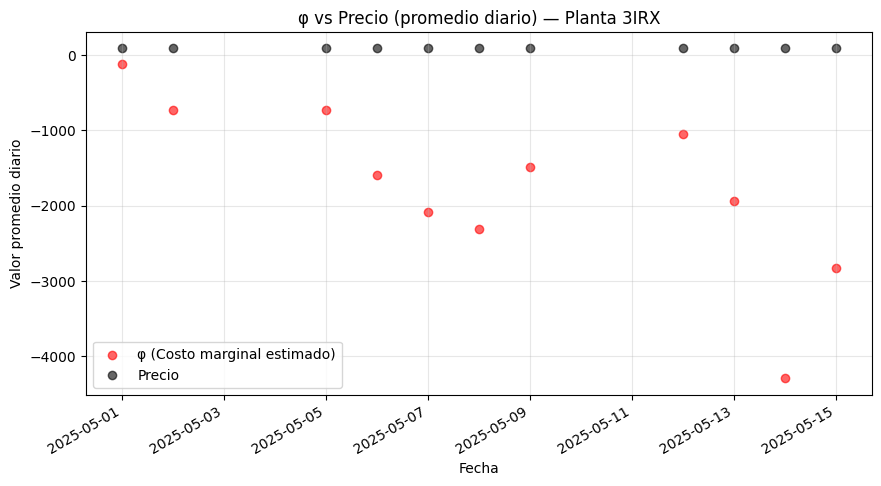

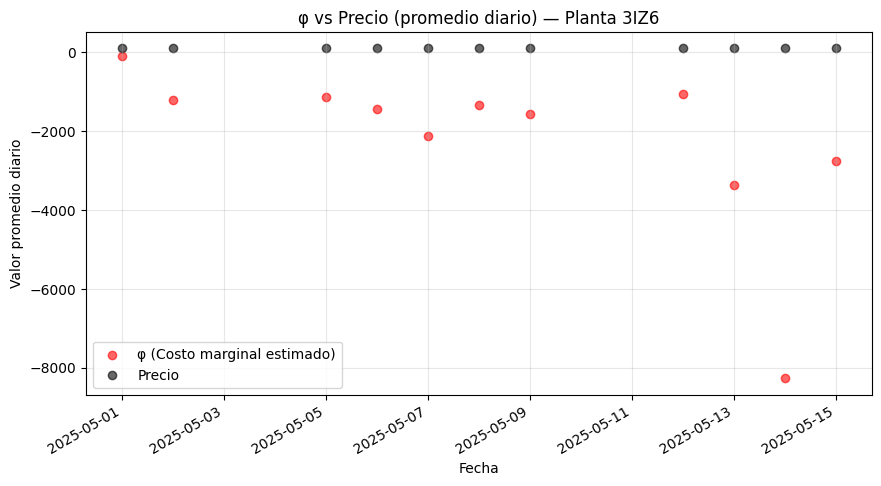

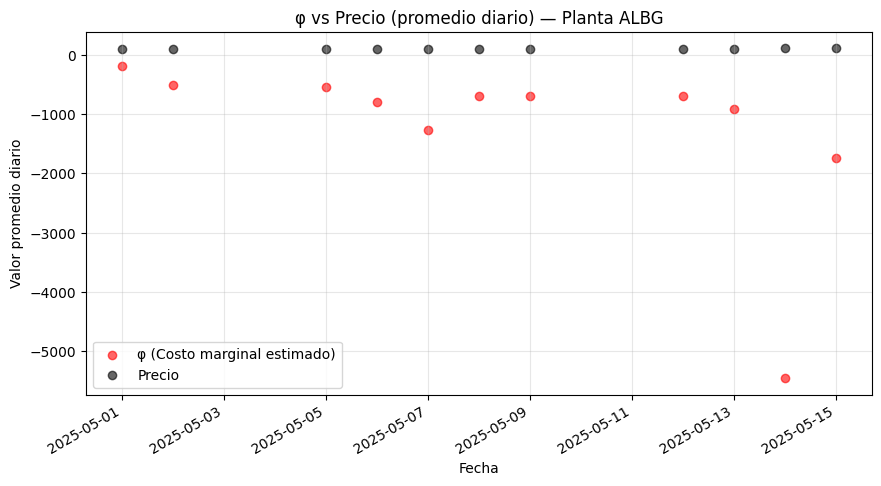

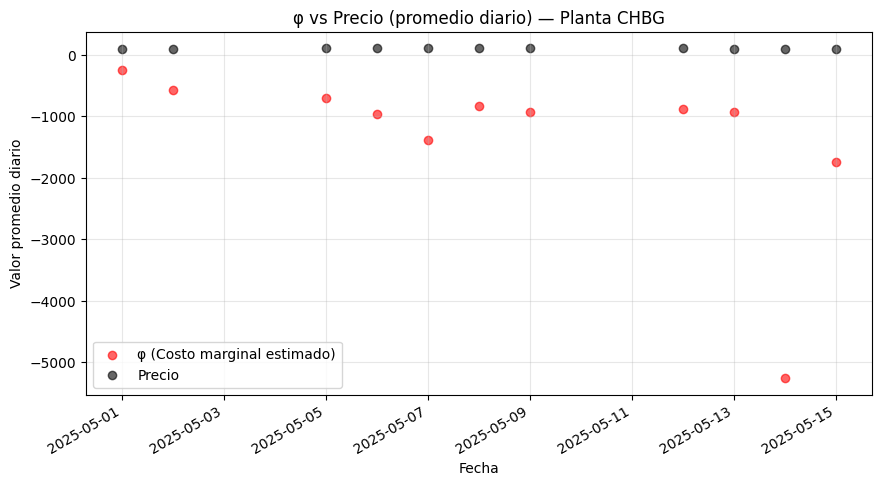

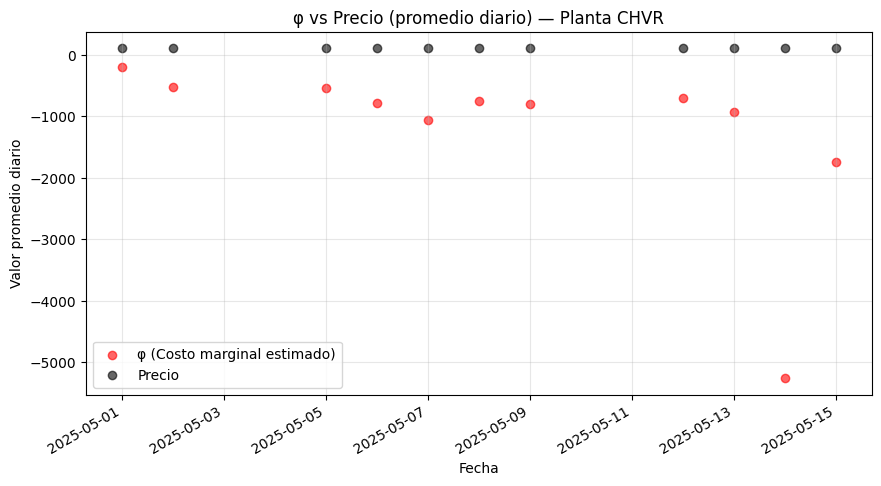

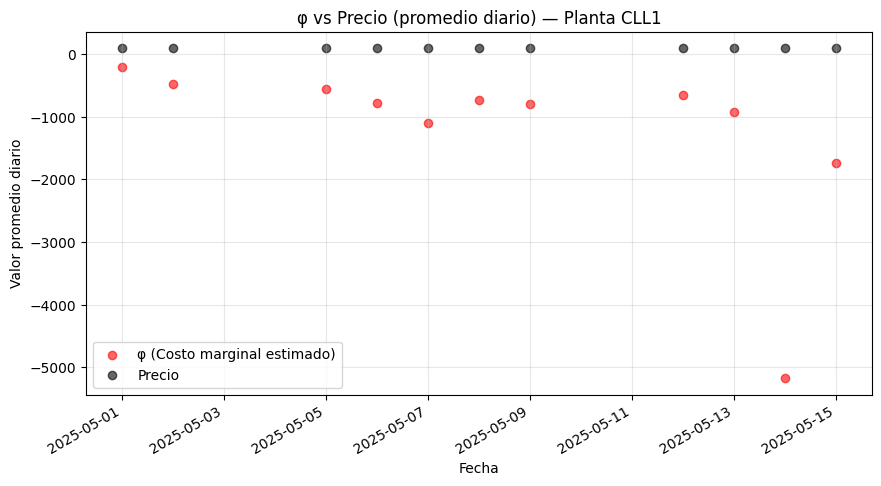

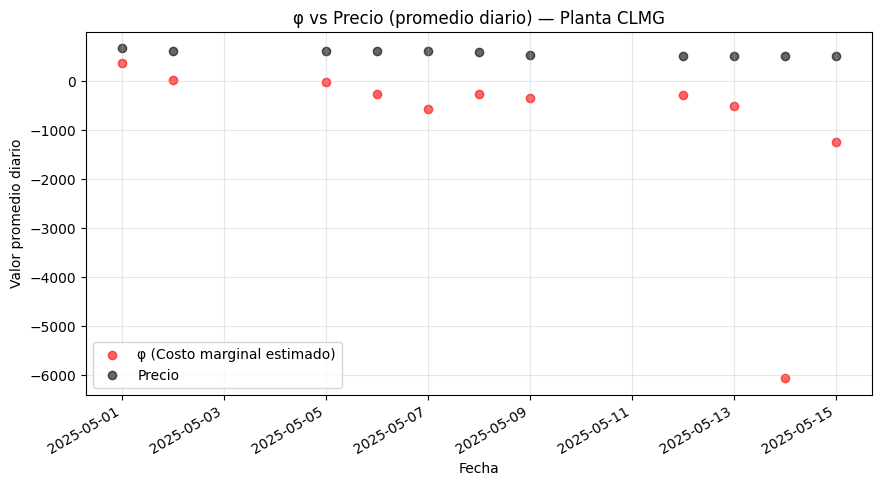

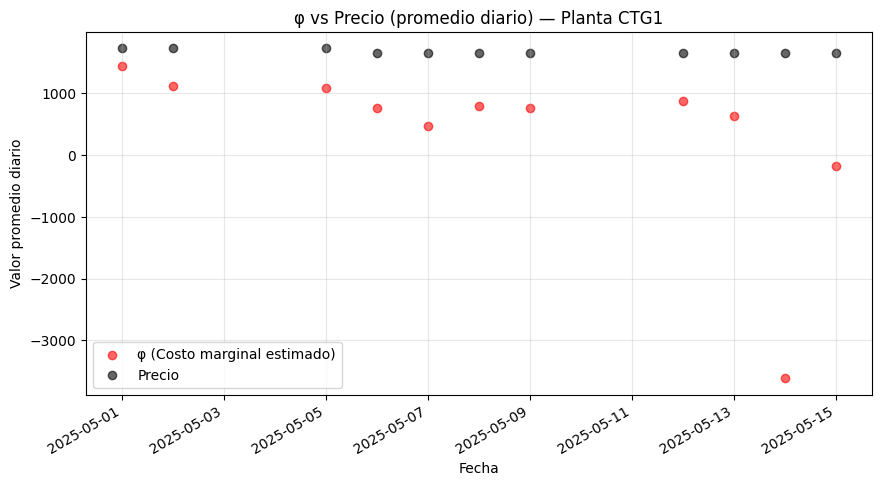

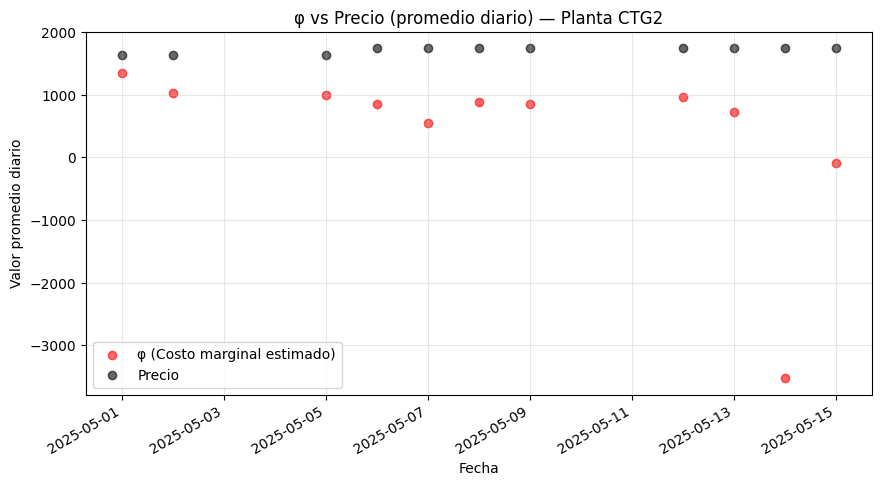

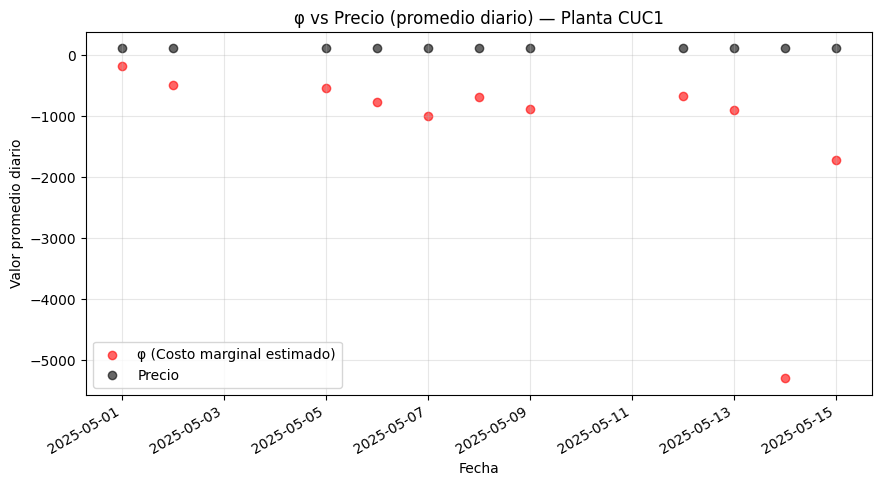

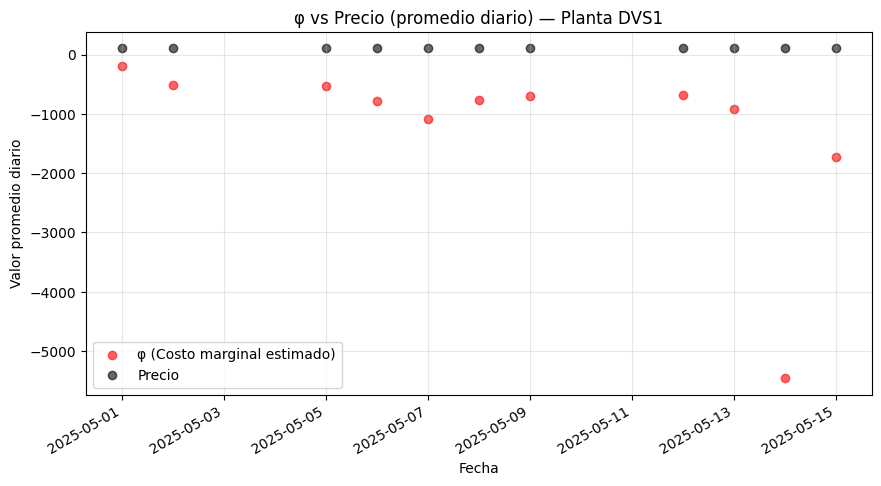

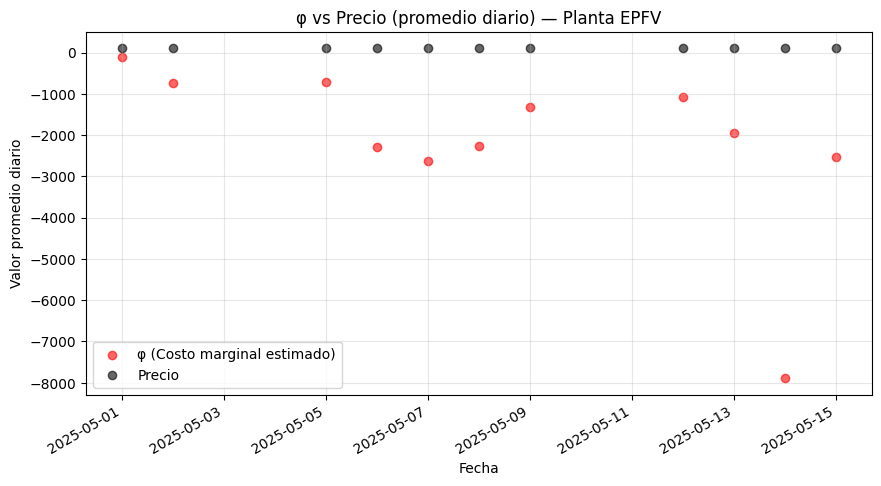

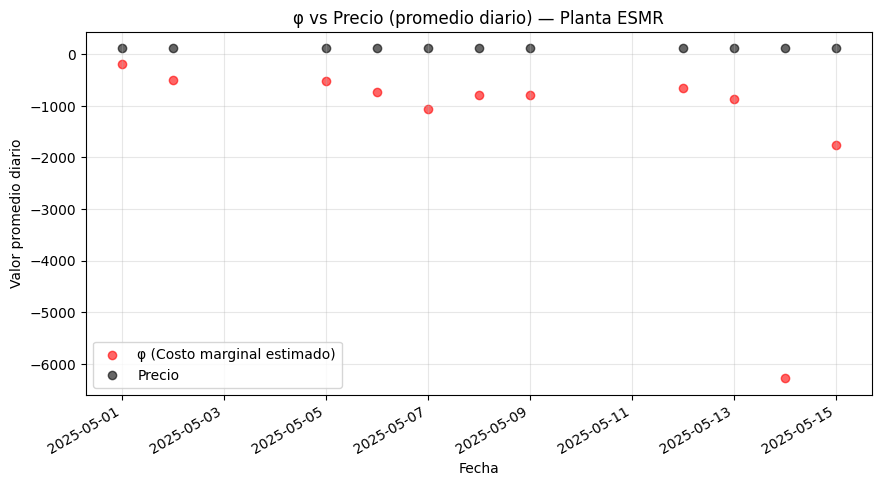

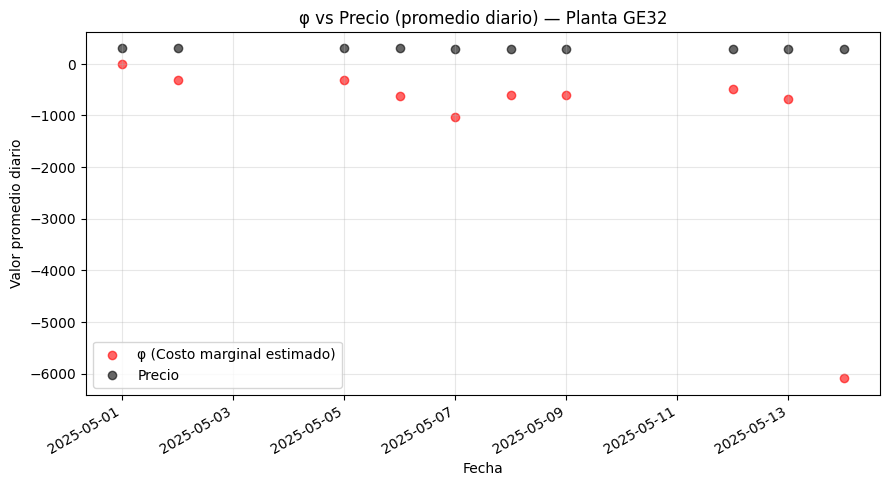

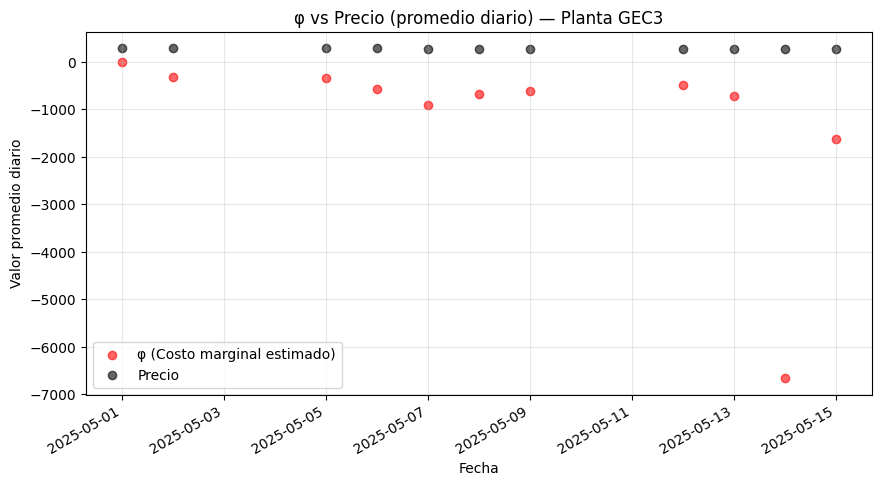

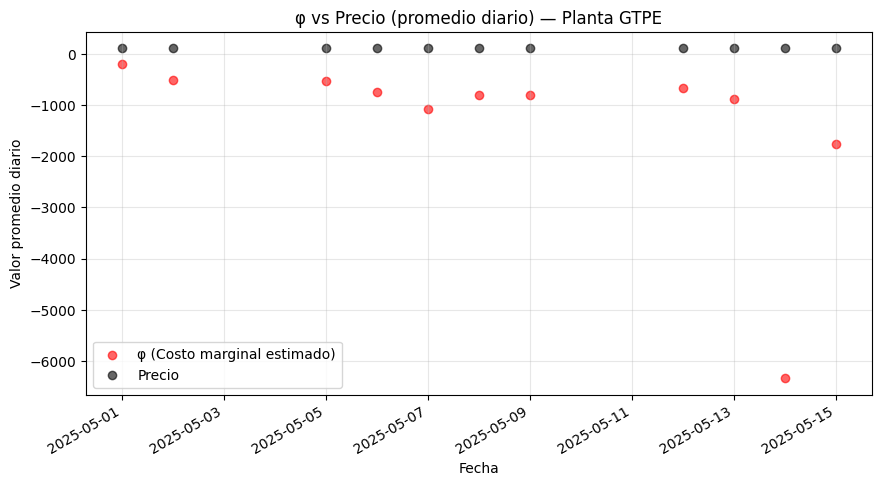

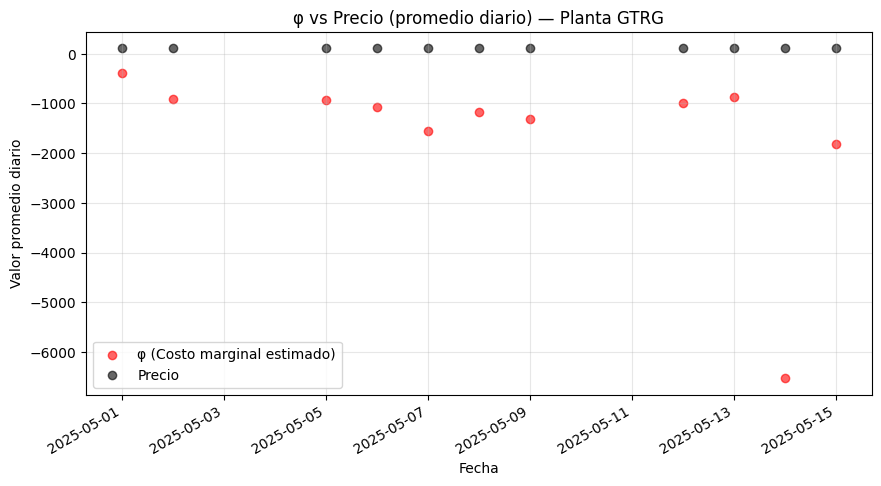

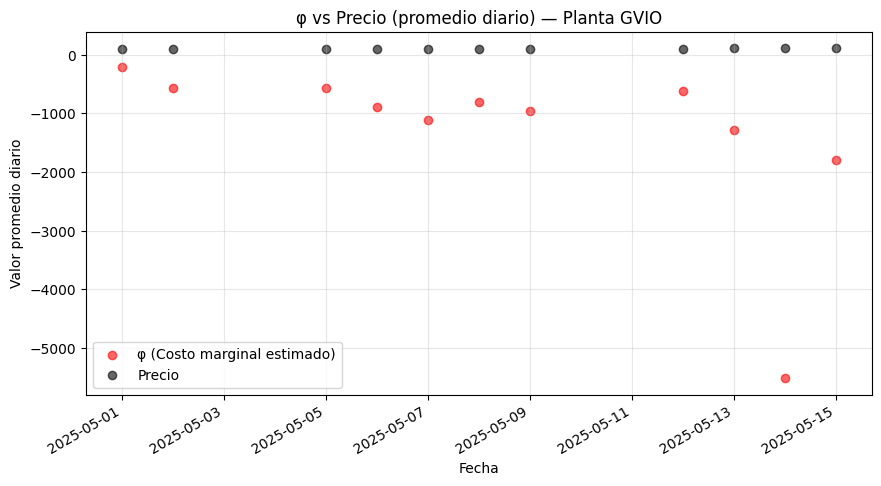

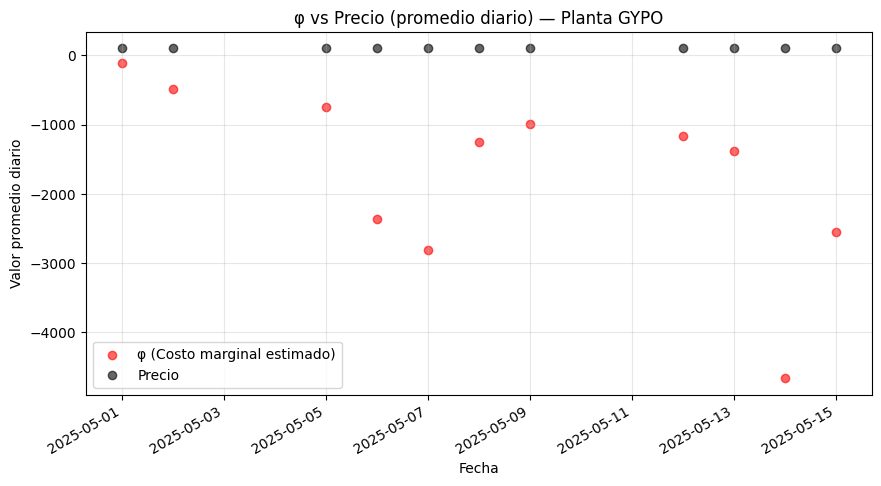

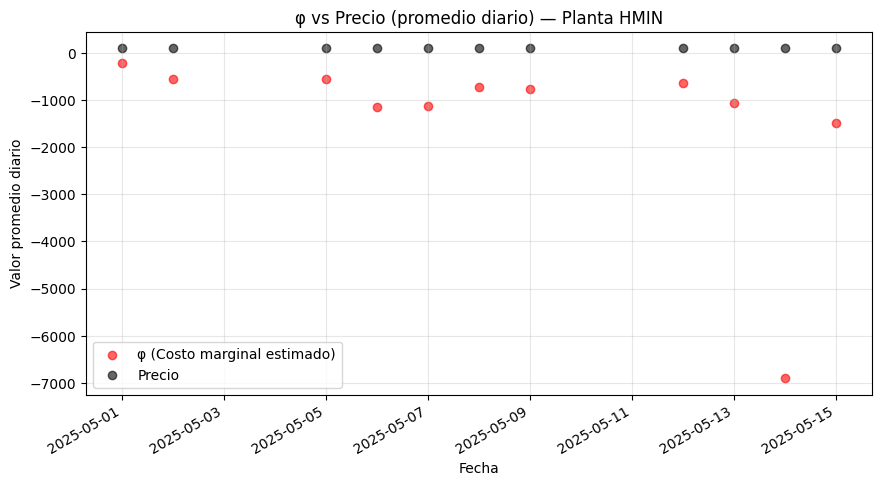

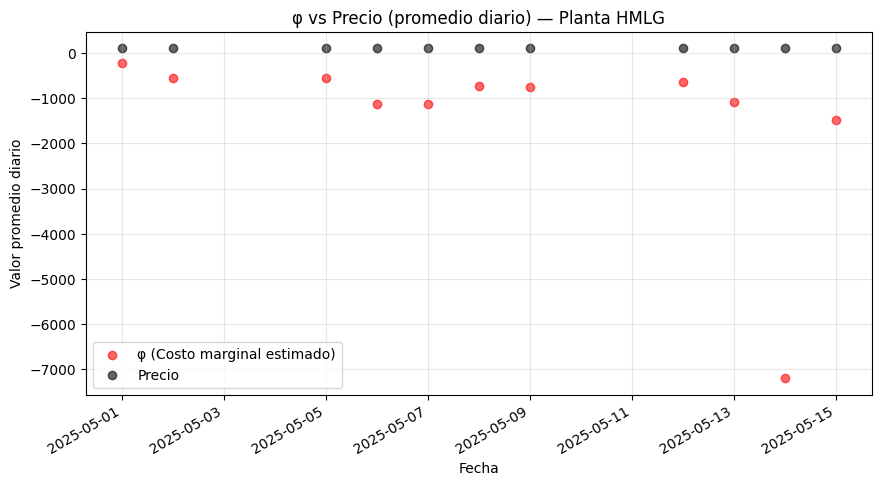

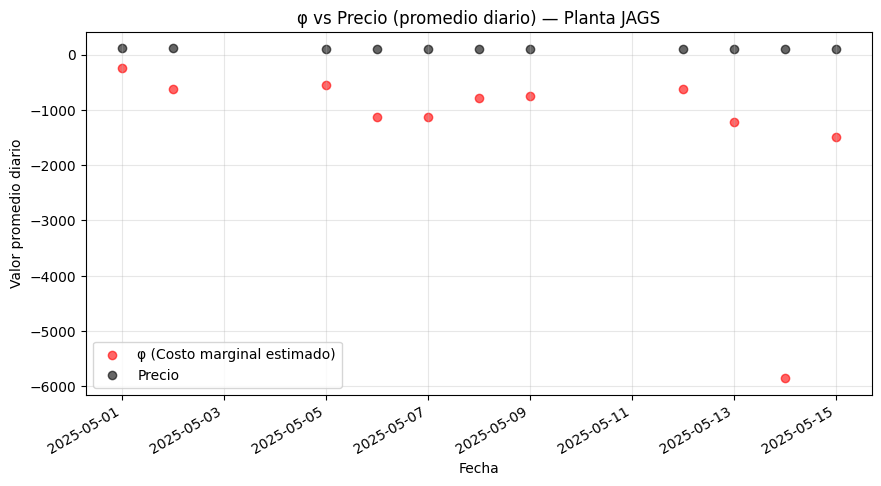

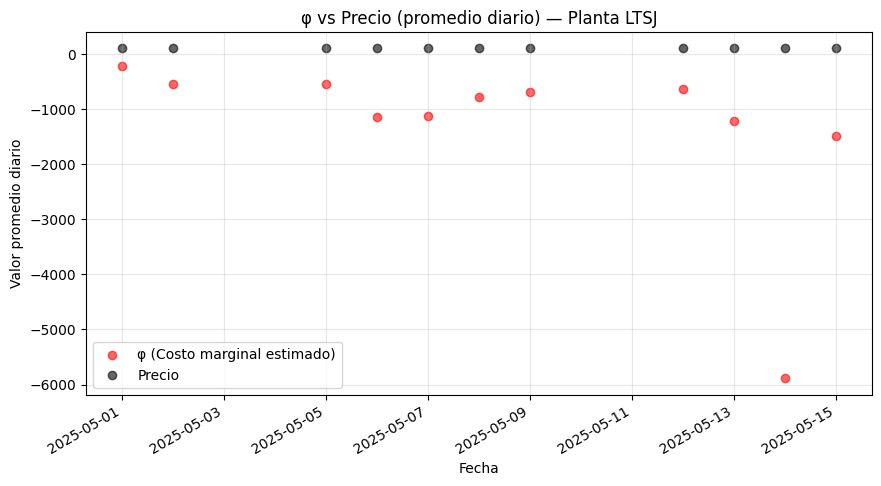

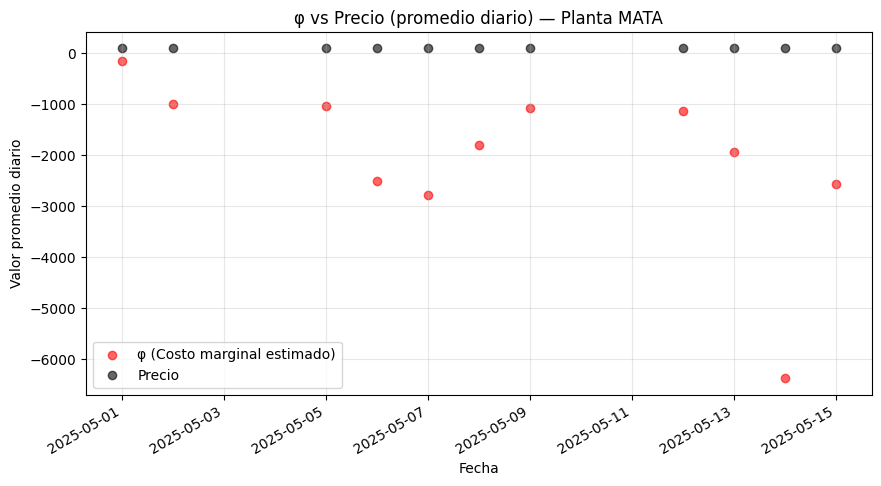

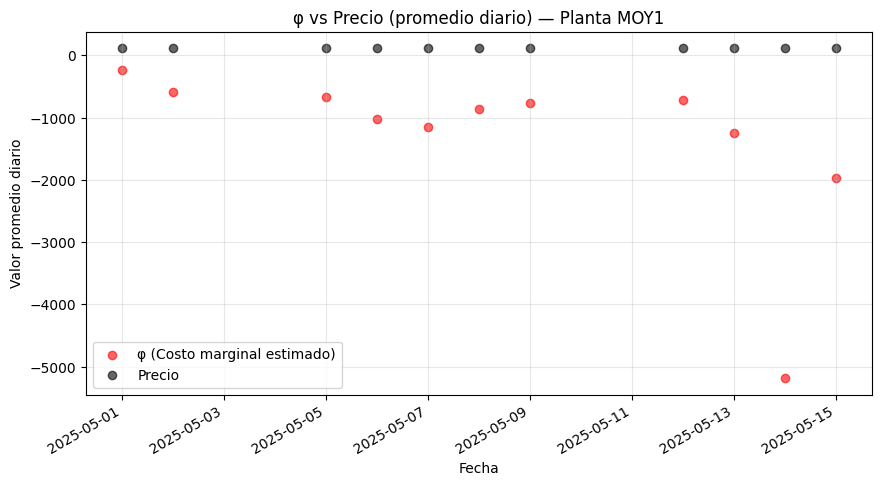

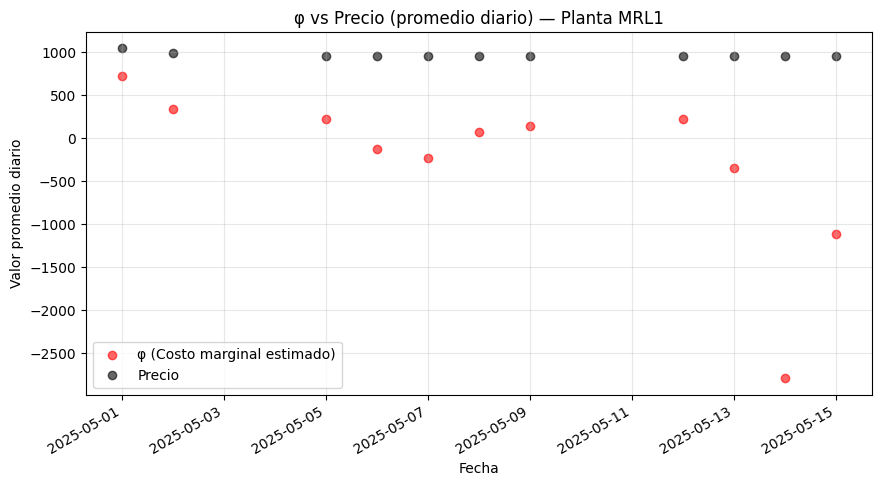

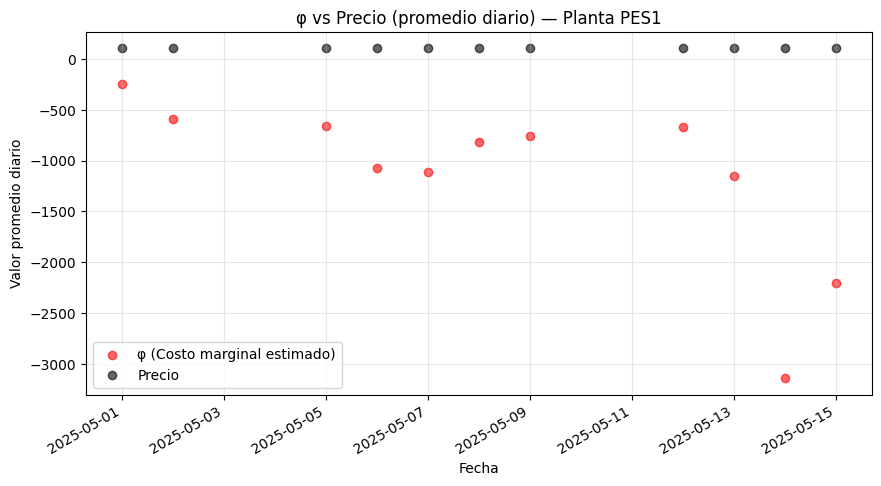

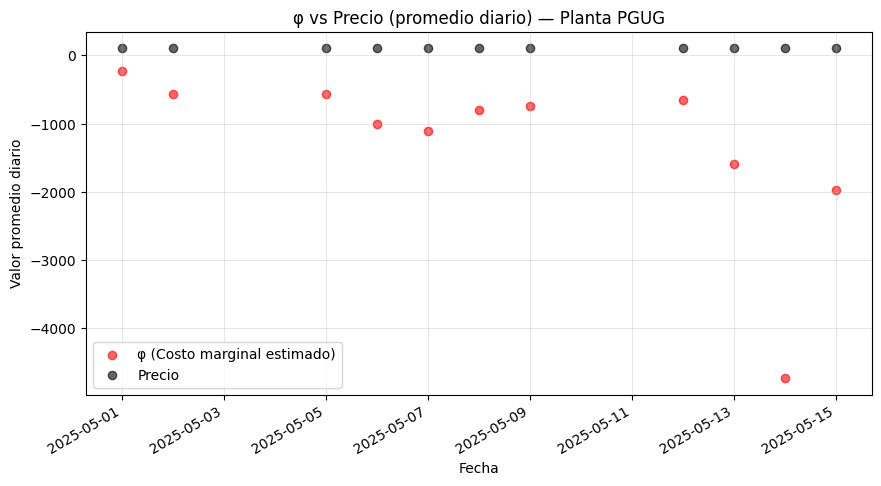

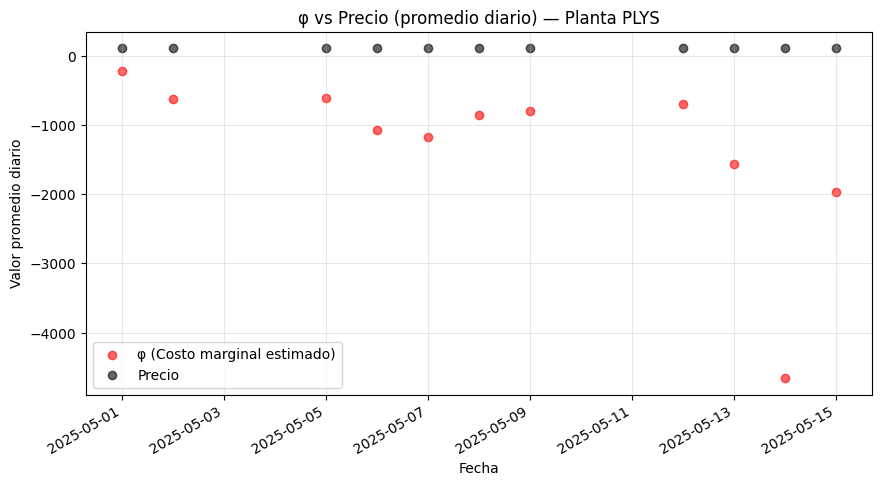

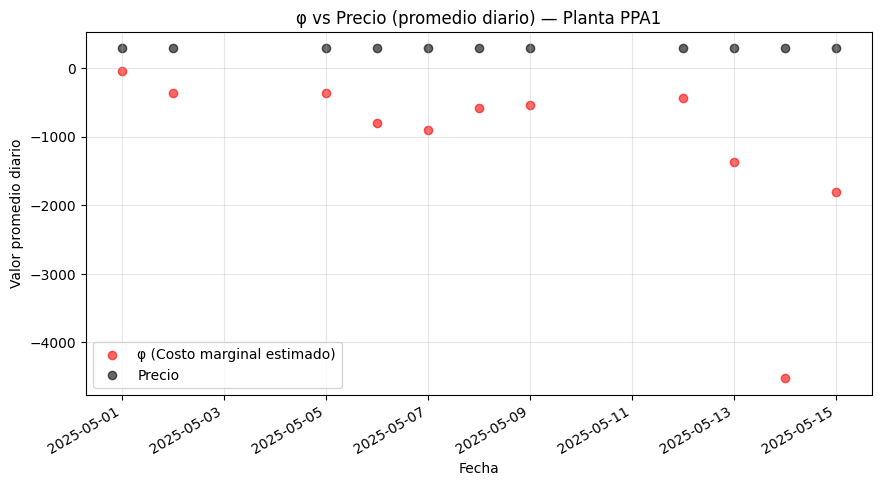

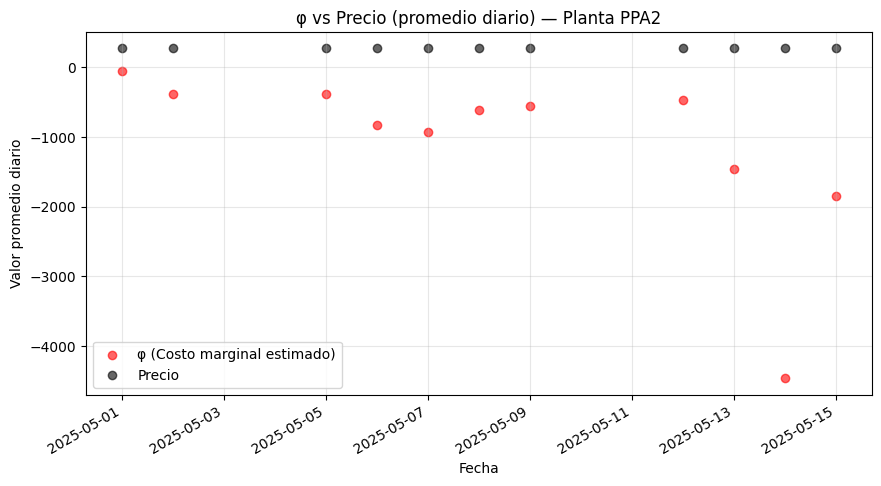

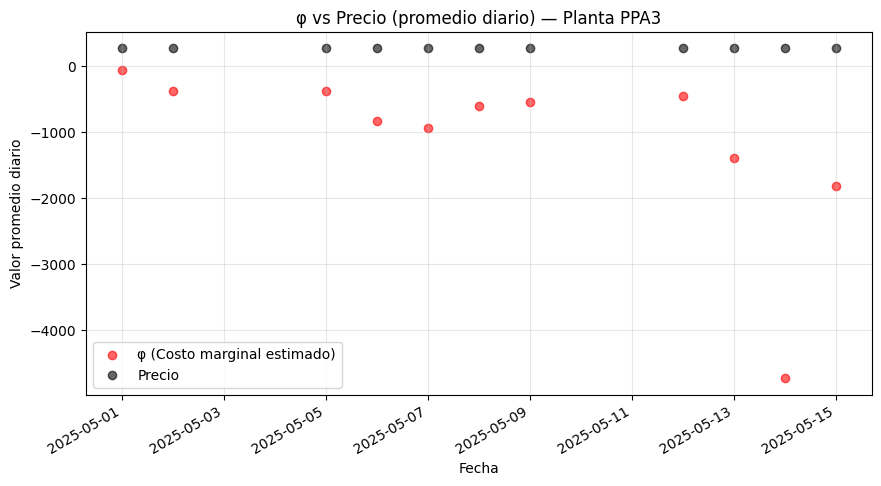

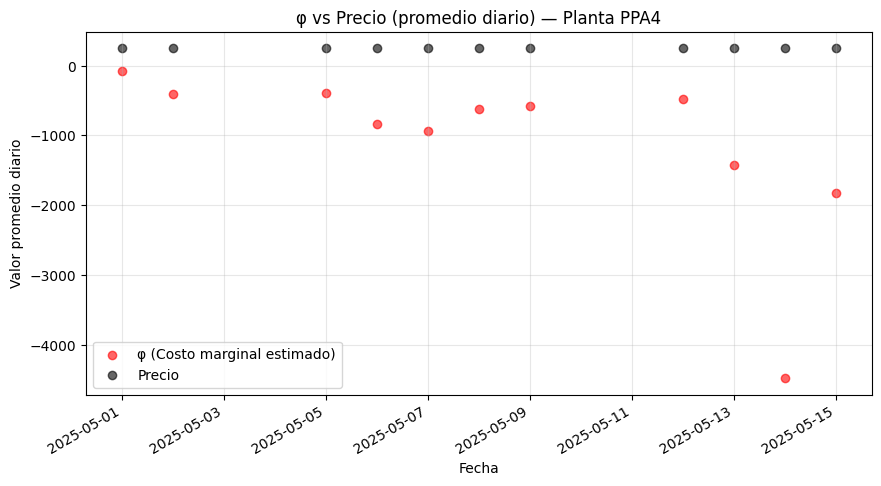

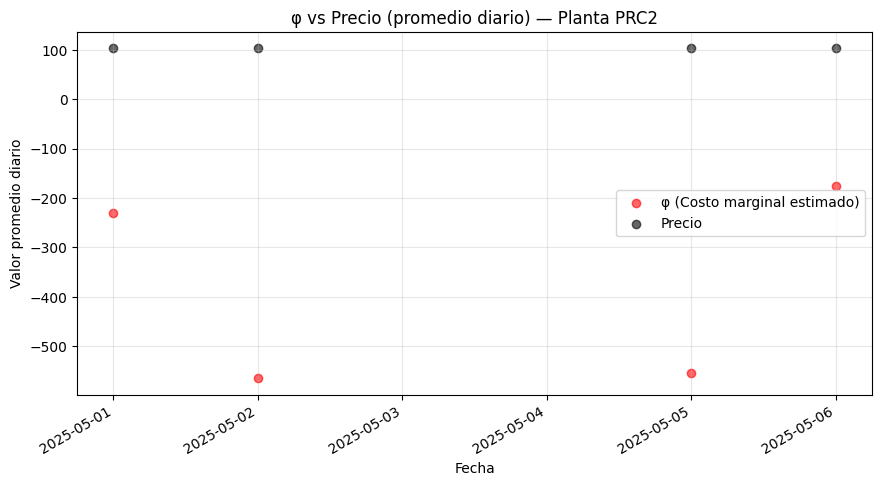

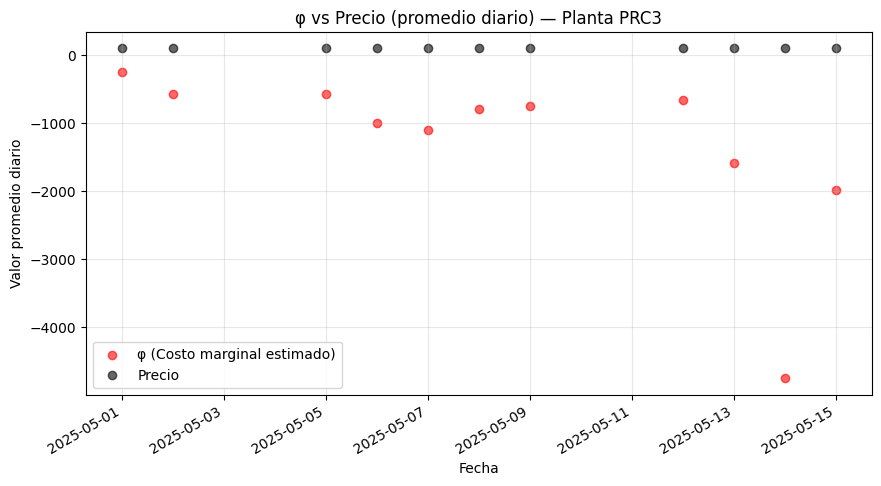

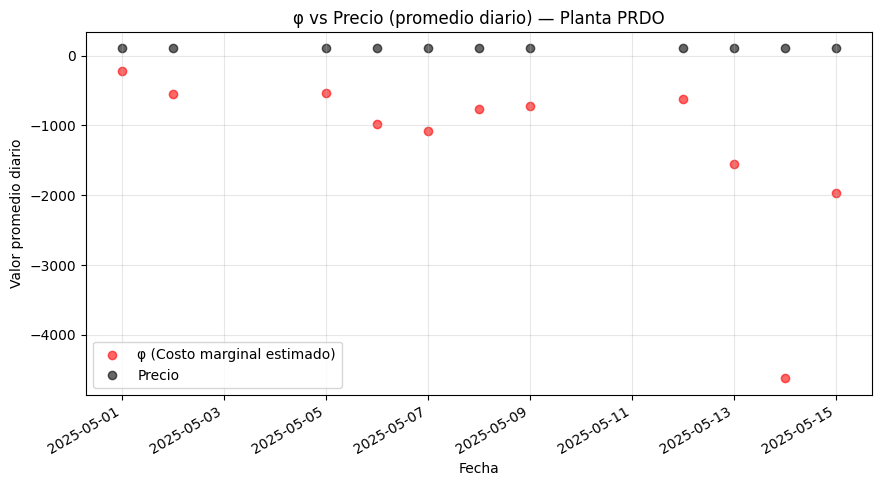

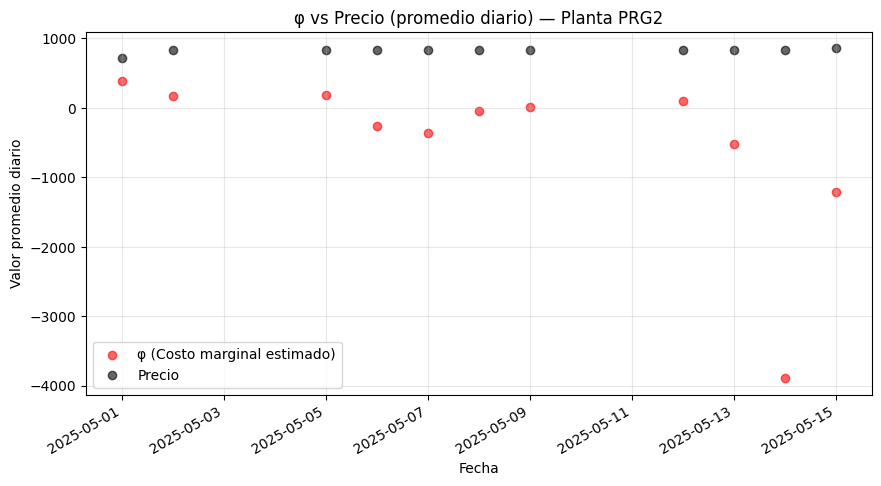

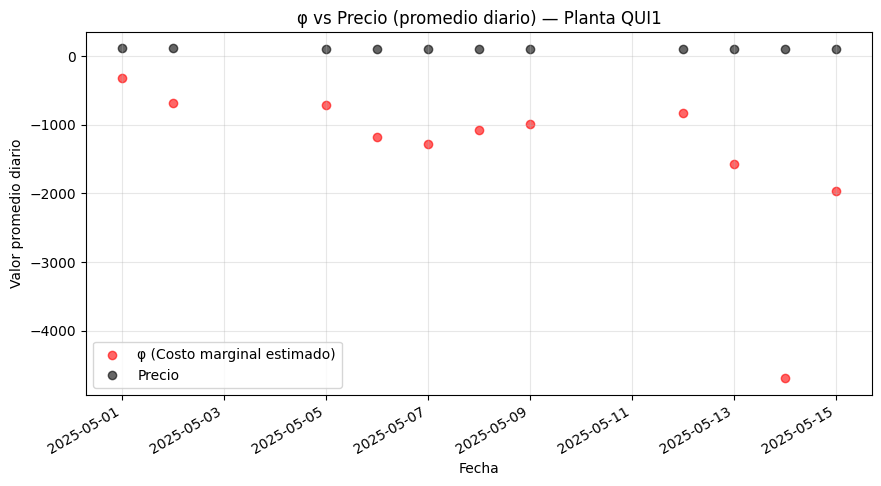

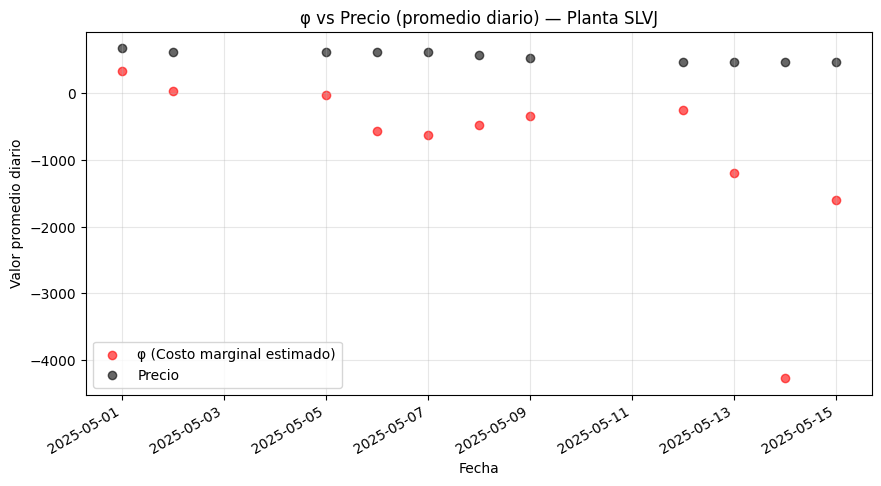

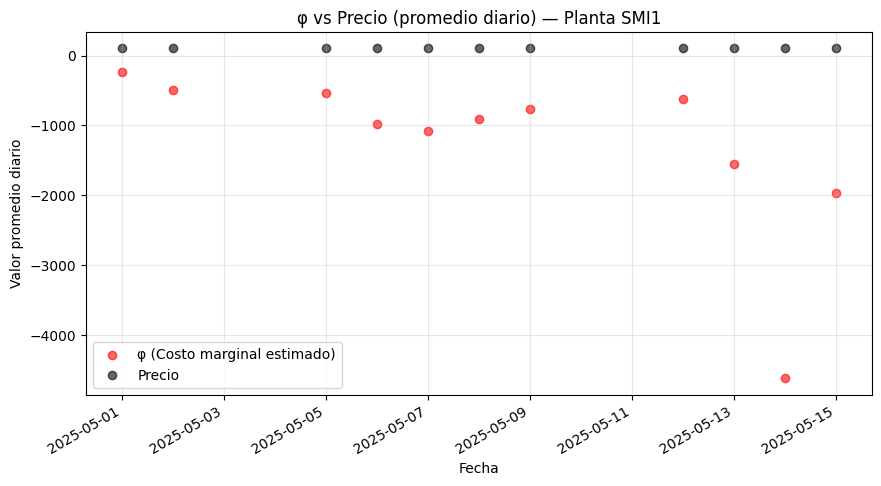

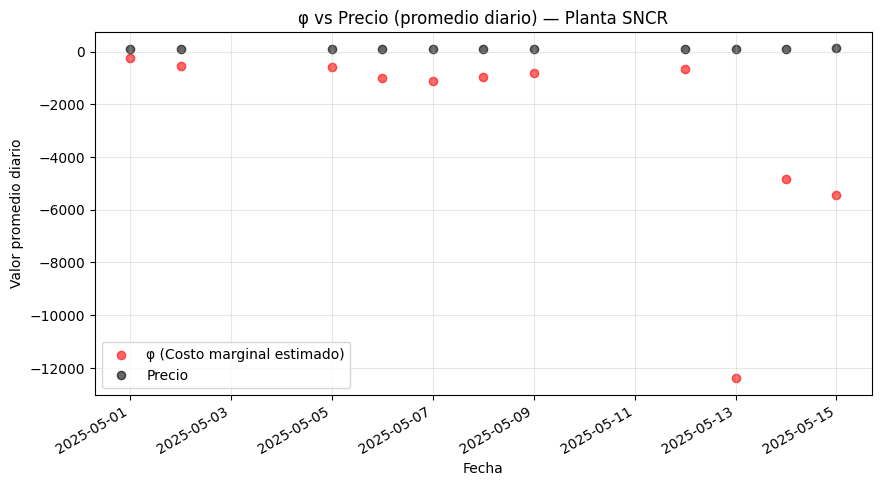

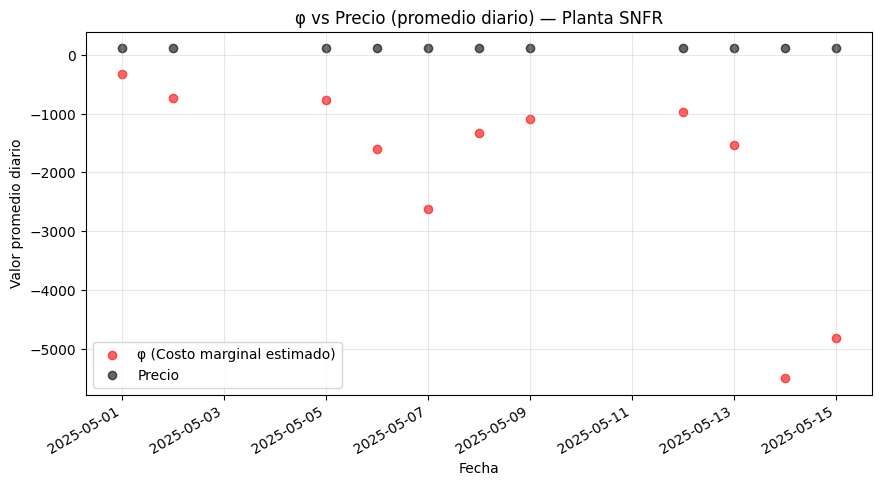

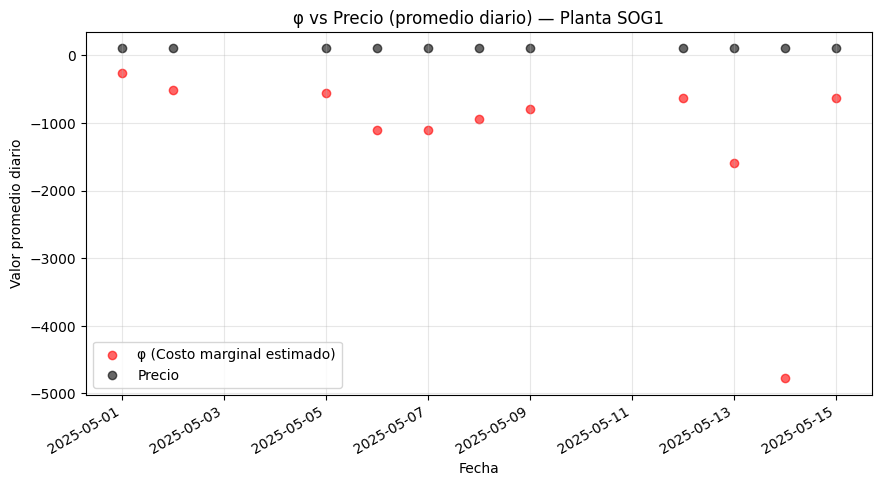

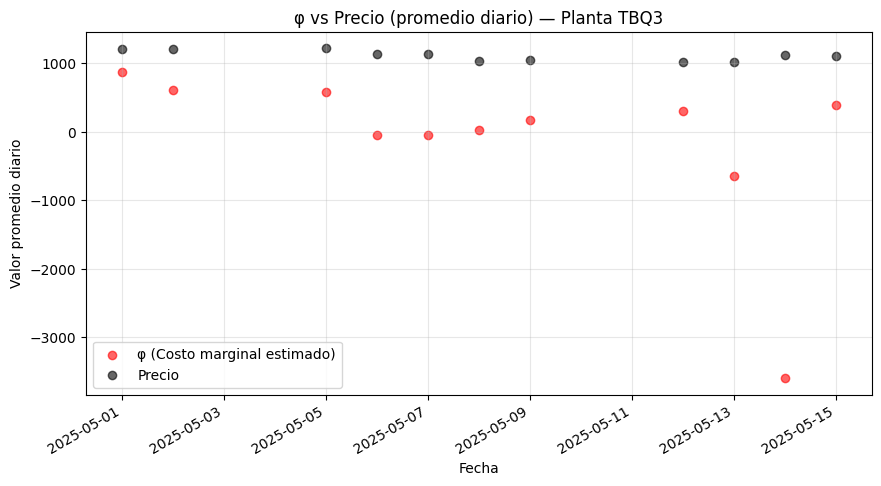

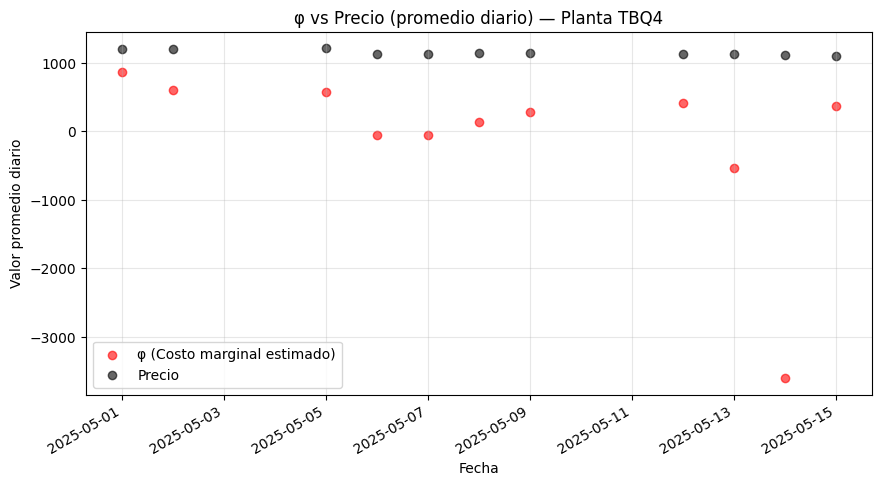

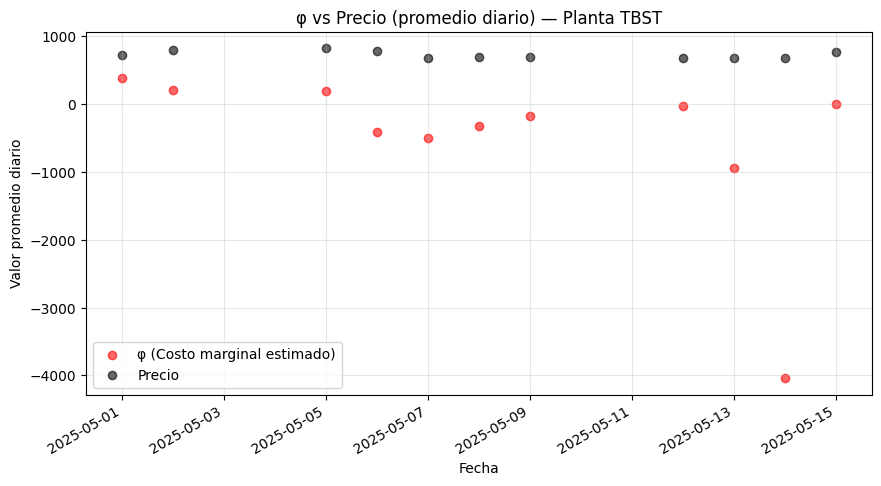

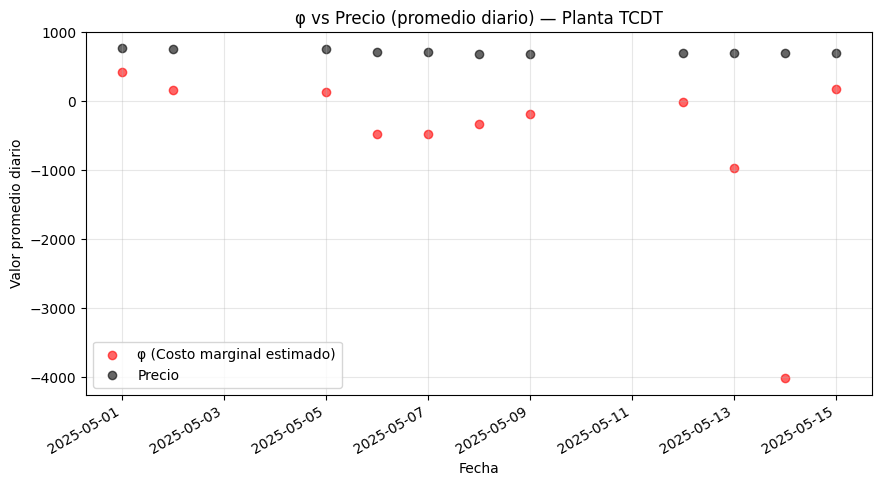

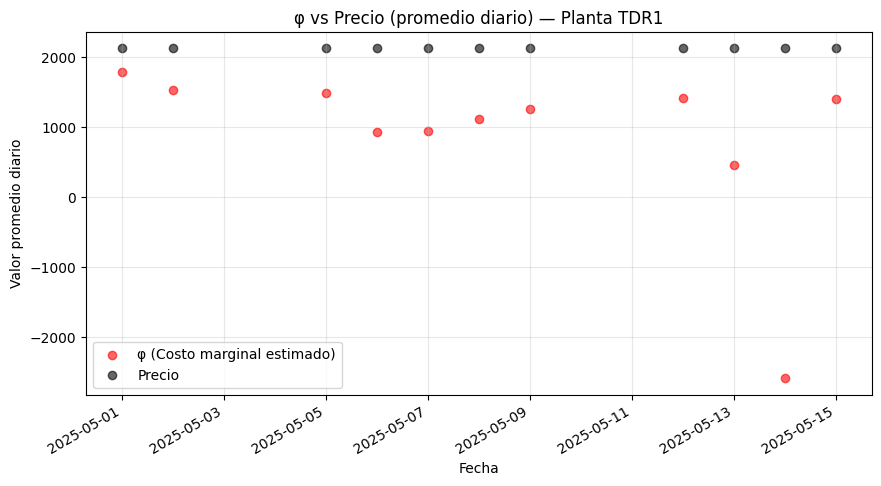

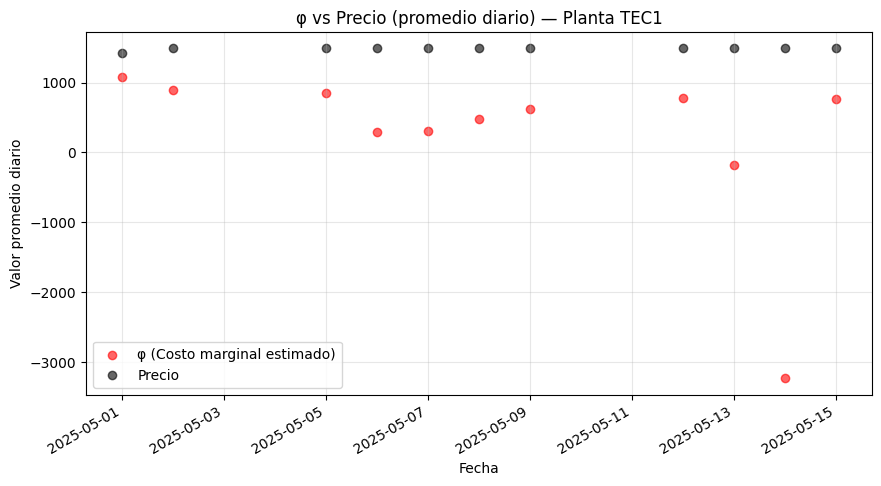

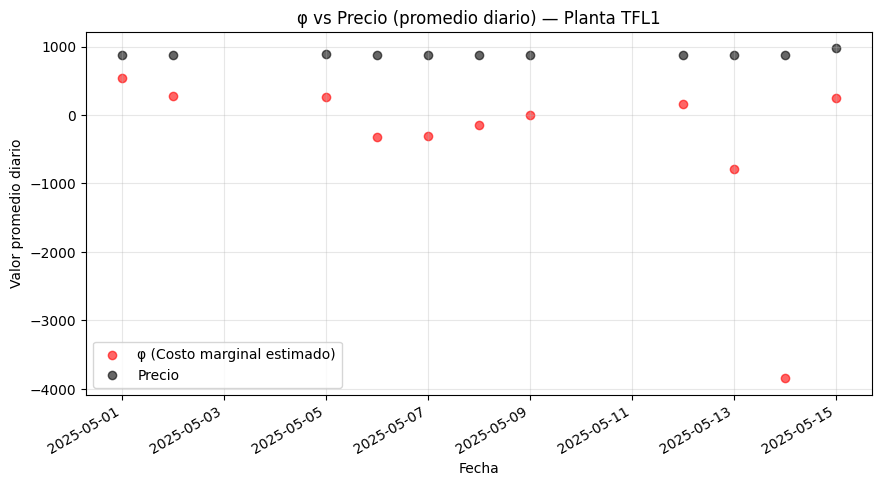

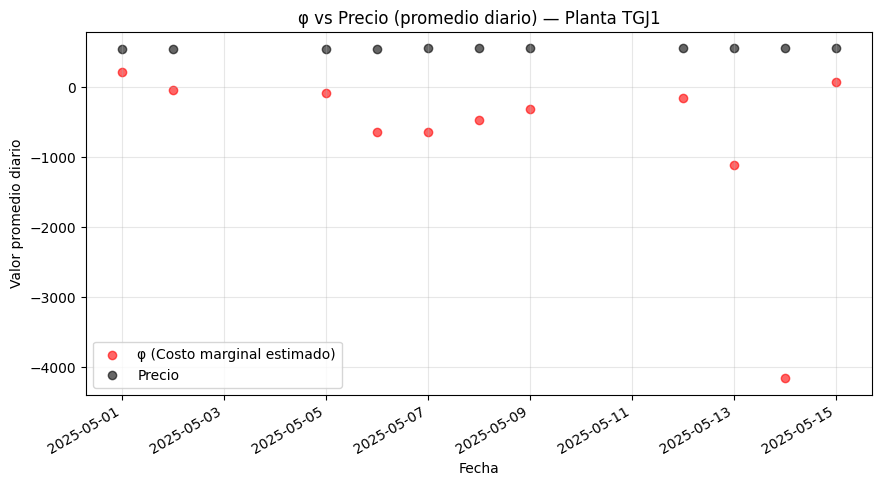

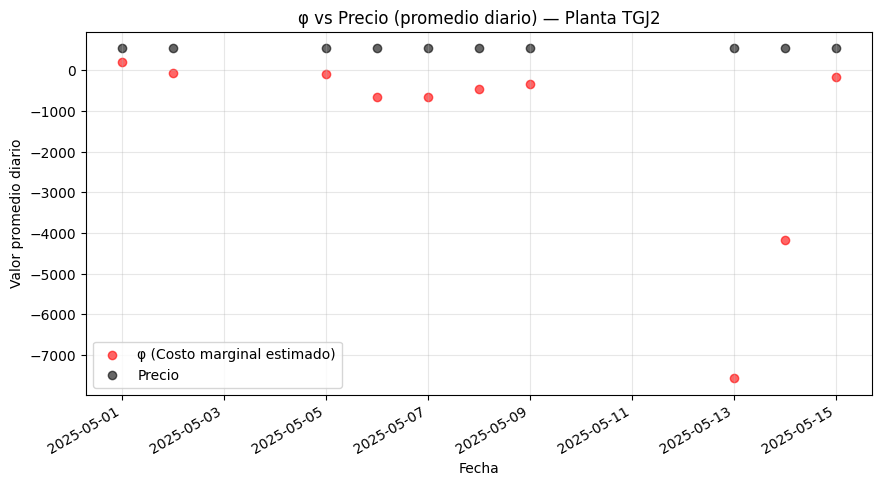

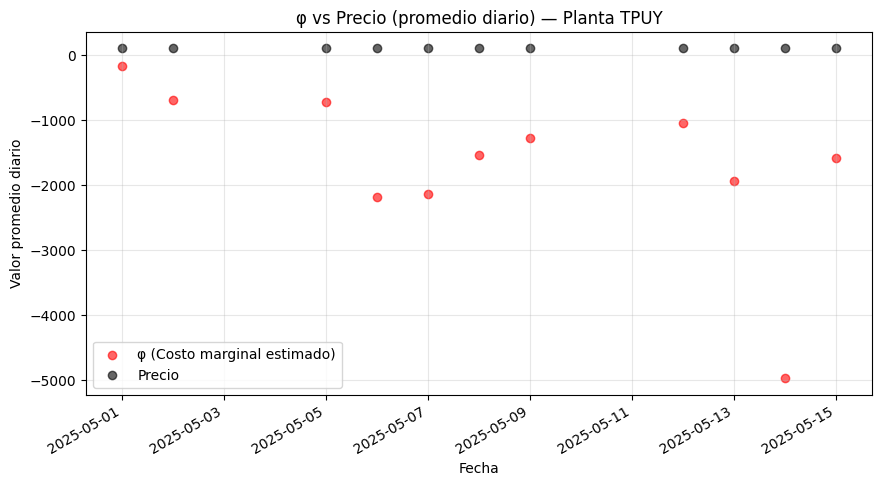

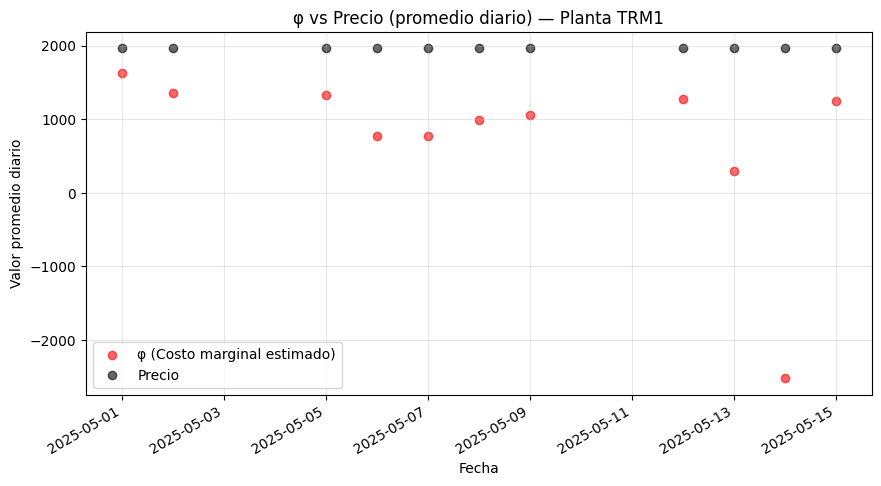

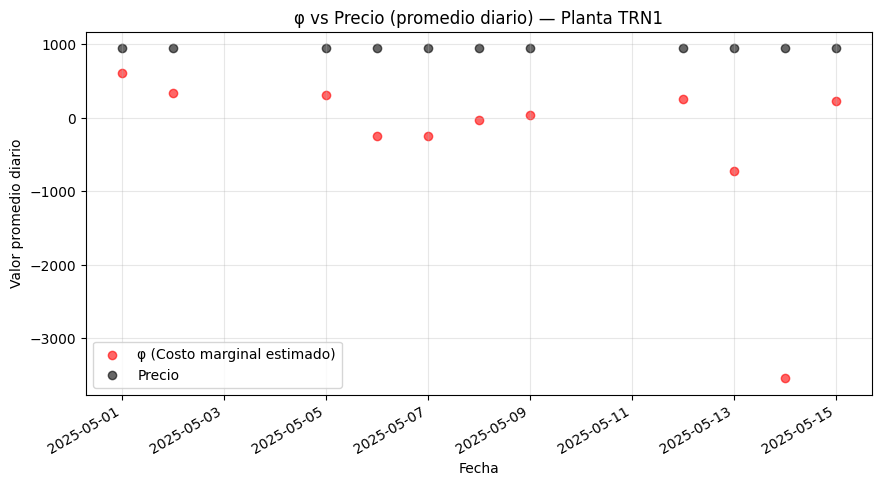

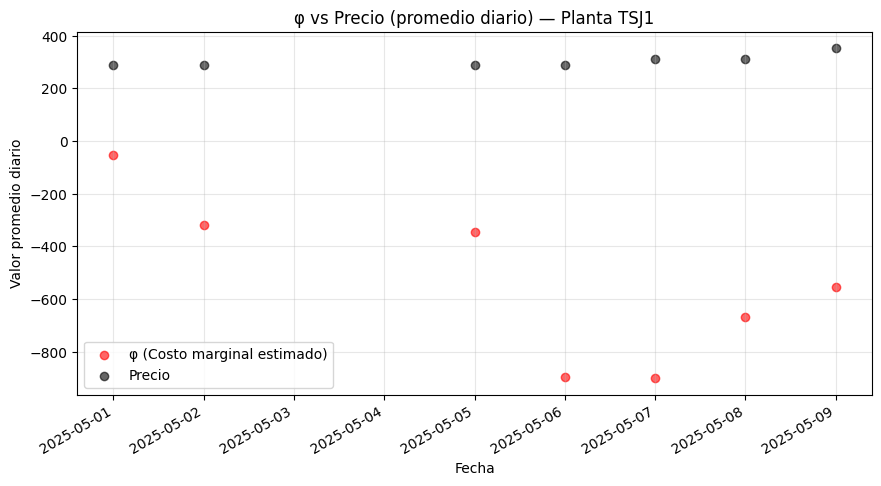

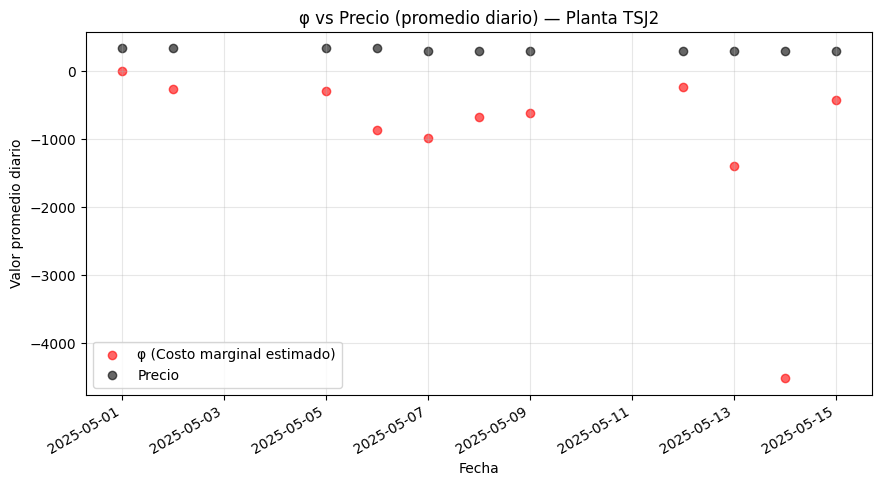

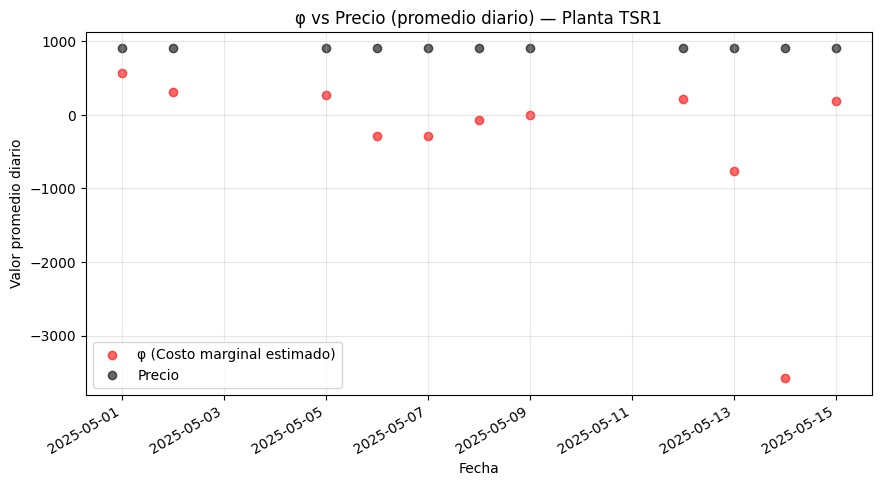

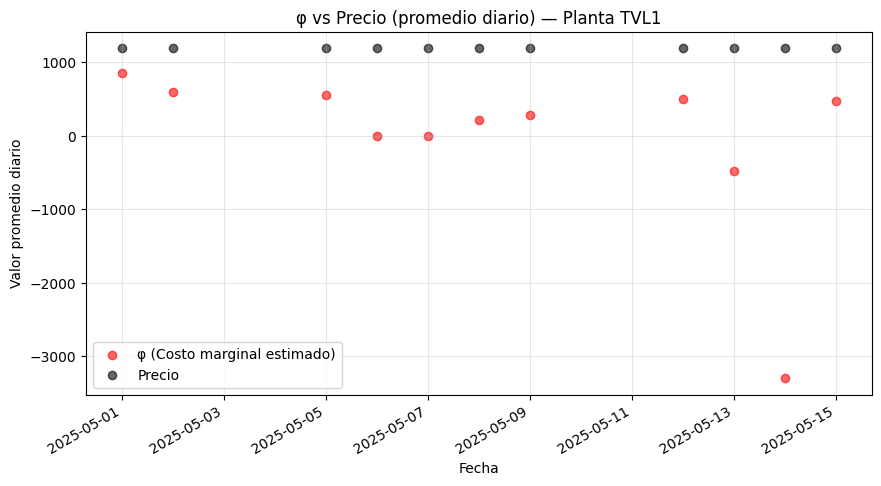

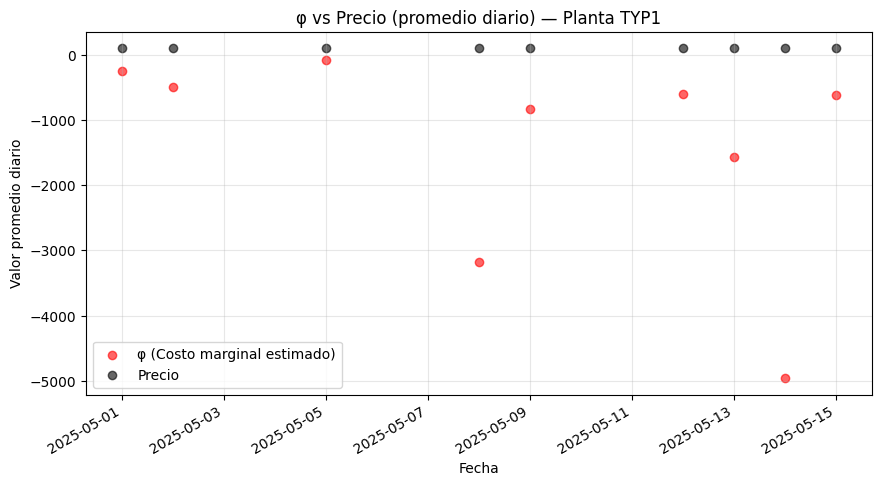

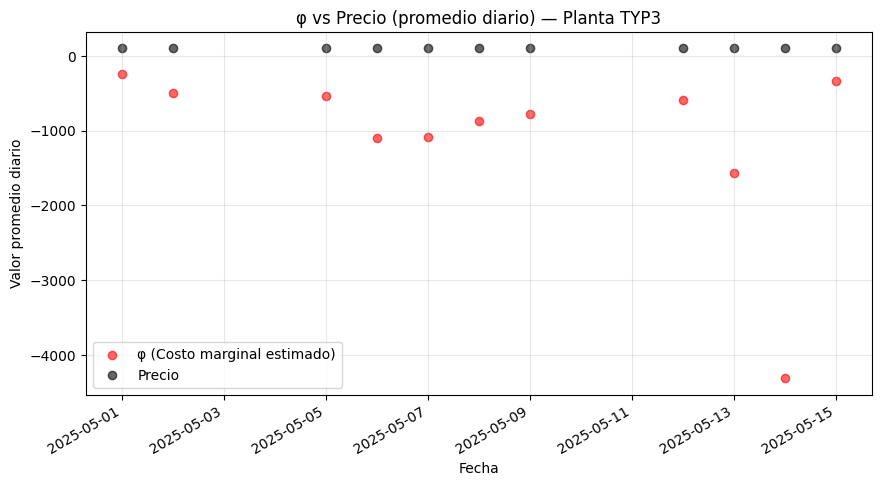

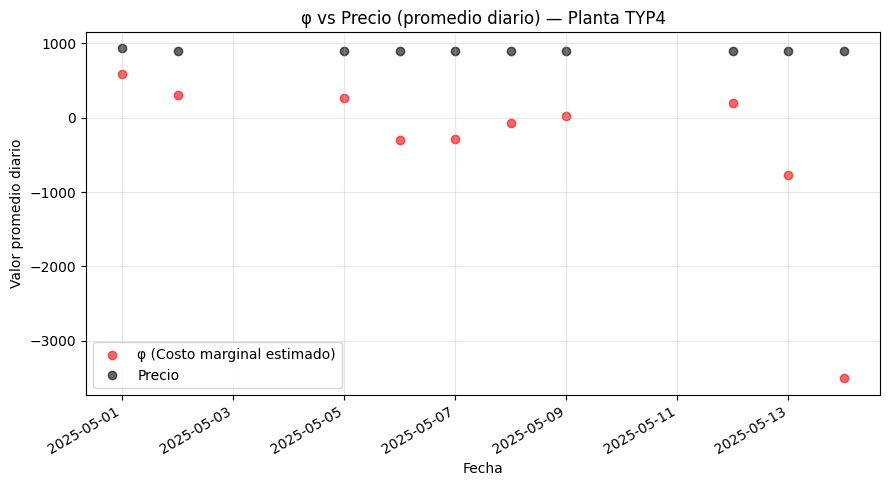

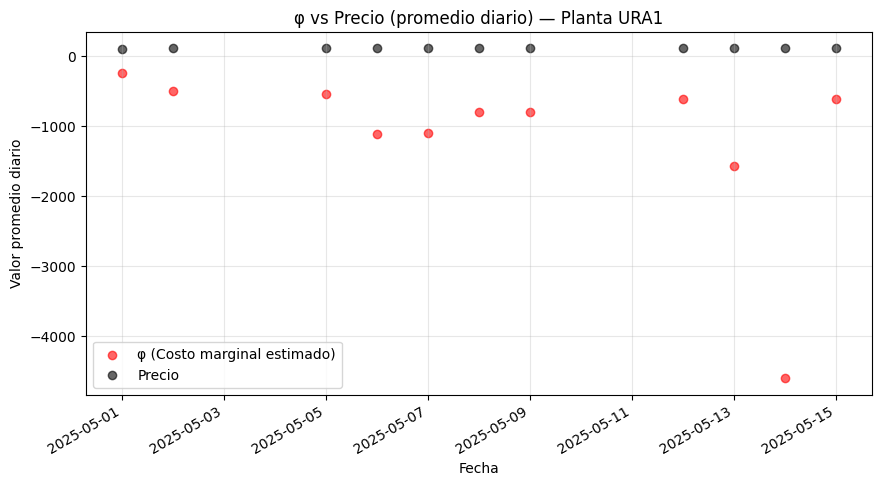

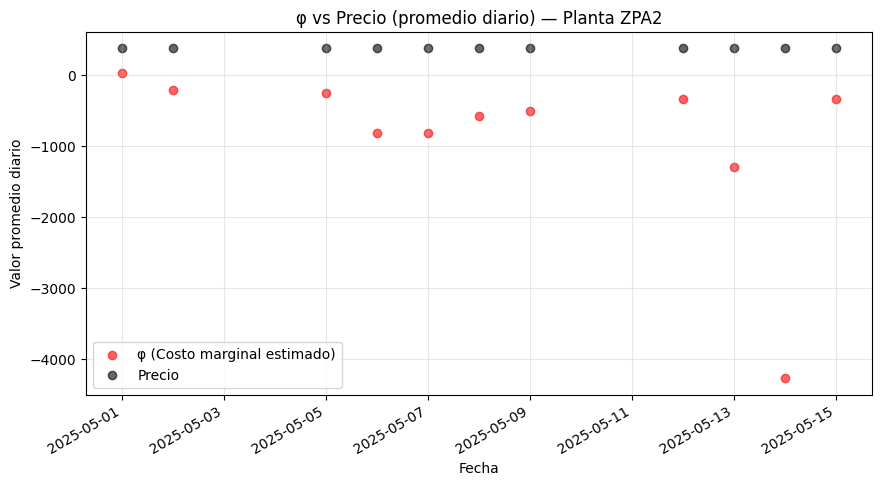

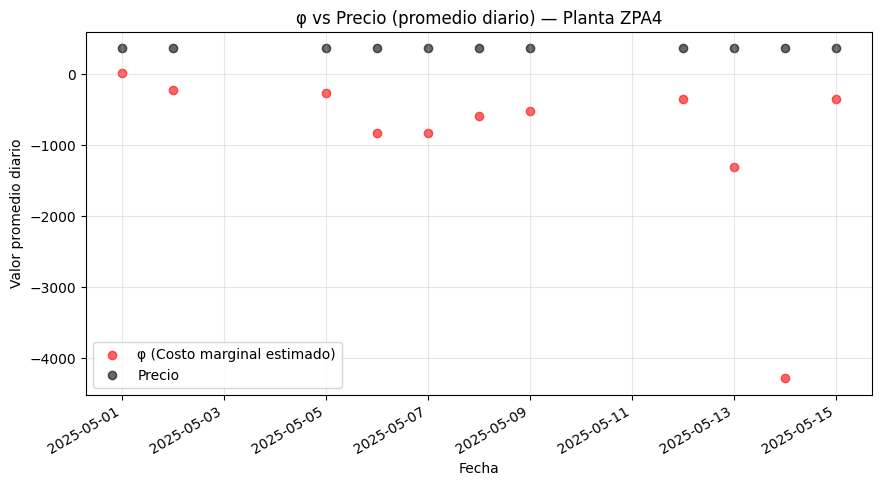

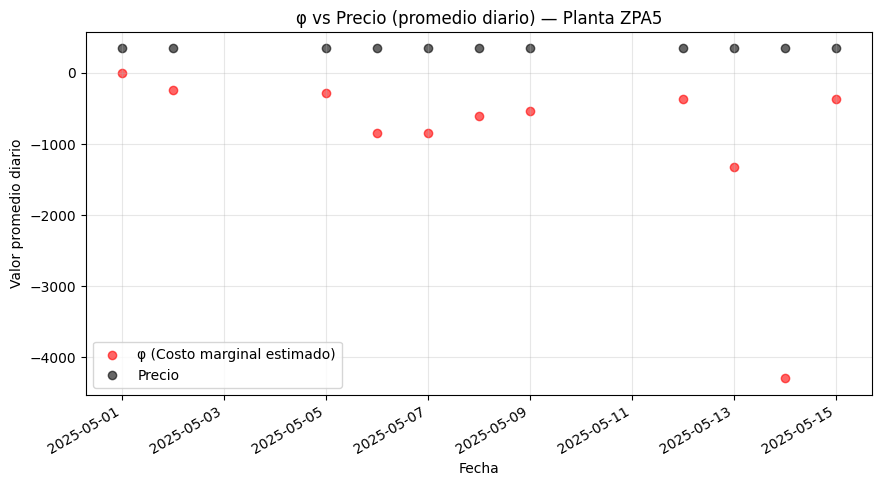

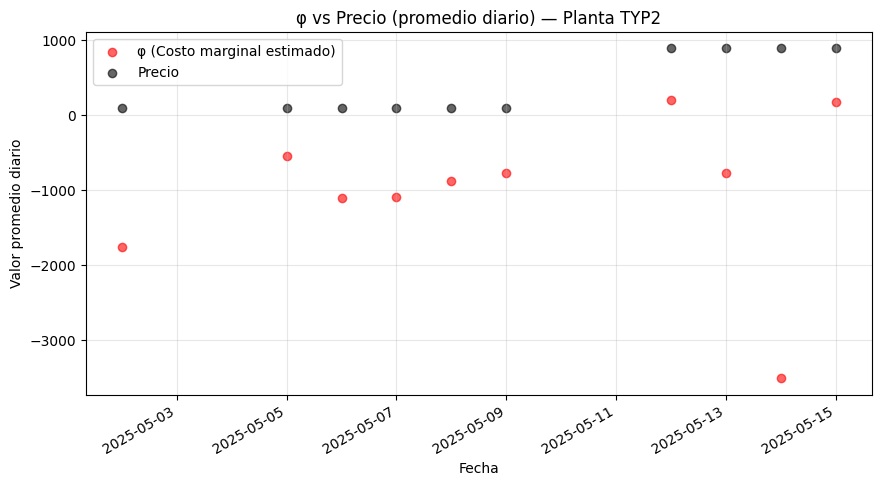

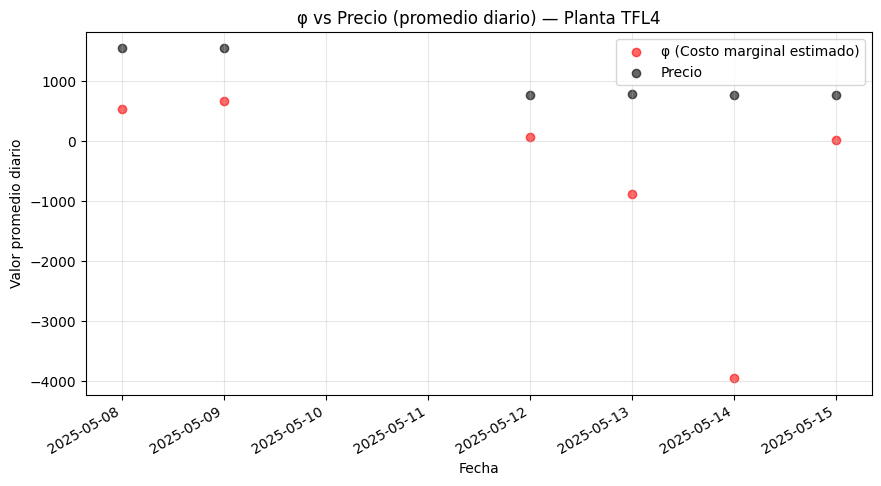

In [40]:

# --- Filtrar filas válidas ---
df_grouped = df_grouped.dropna(subset=['Fecha', 'CodigoPlanta', 'phi', 'precio_d'])

# --- Iterar sobre cada planta ---
for planta in df_grouped['CodigoPlanta'].unique():
    df_planta = (
        df_grouped[df_grouped['CodigoPlanta'] == planta]
        .groupby('Fecha', as_index=False)[['phi', 'precio_d']].mean()
        .sort_values('Fecha')
    )

    plt.figure(figsize=(9, 5))
    plt.scatter(df_planta['Fecha'], df_planta['phi'], color='red', label='φ (Costo marginal estimado)', alpha=0.6)
    plt.scatter(df_planta['Fecha'], df_planta['precio_d'], color='black', label='Precio', alpha=0.6)

    plt.xlabel("Fecha")
    plt.ylabel("Valor promedio diario")
    plt.title(f"φ vs Precio (promedio diario) — Planta {planta}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()

    # --- Guardar figura ---
    fecha_min = df_planta['Fecha'].min()
    fecha_max = df_planta['Fecha'].max()
    filename = f"phi_precio_{planta}_{fecha_min}_to_{fecha_max}_M{M}.png"
    filepath = os.path.join(sub_dir, filename)
    plt.savefig(filepath, dpi=300)
    plt.show()

    #print(f"✅ Gráfico guardado: {filepath}")


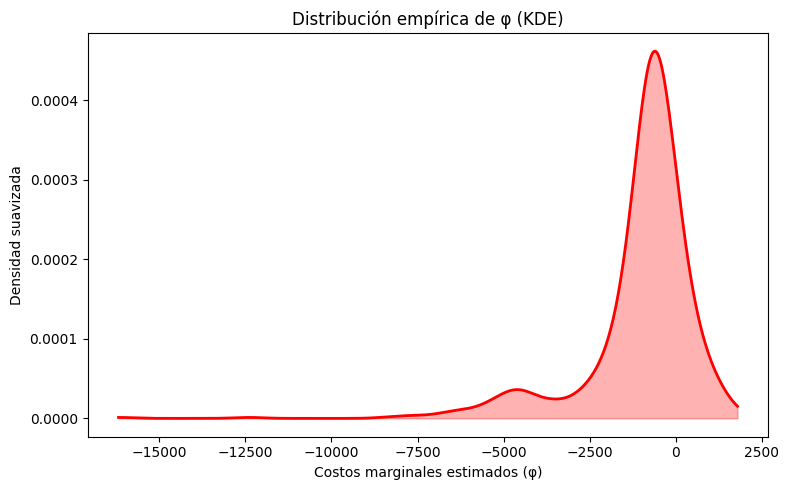

In [41]:

phi = pd.to_numeric(df_grouped['phi'], errors='coerce').dropna()

# Calcular densidad KDE
kde = gaussian_kde(phi)
x_vals = np.linspace(phi.min(), phi.max(), 500)
y_vals = kde(x_vals)

plt.figure(figsize=(8,5))
plt.plot(x_vals, y_vals, color="red", linewidth=2)
plt.fill_between(x_vals, y_vals, color="red", alpha=0.3)
plt.xlabel("Costos marginales estimados (φ)")
plt.ylabel("Densidad suavizada")
plt.title("Distribución empírica de φ (KDE)")
plt.tight_layout()
plt.show()


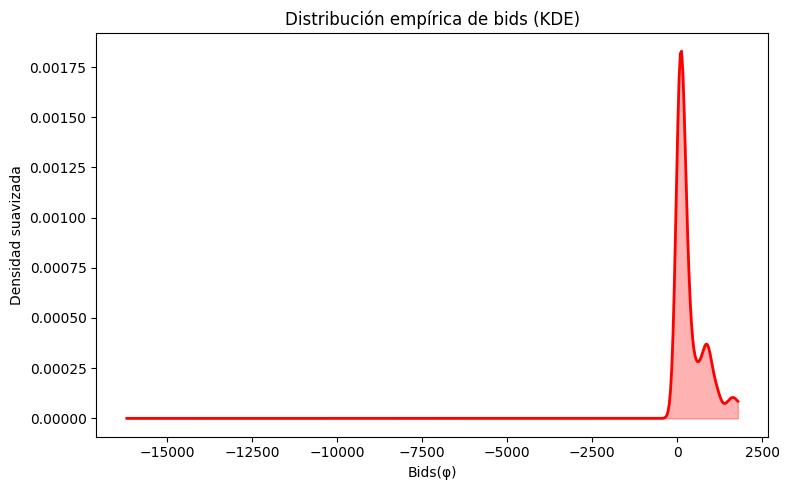

In [42]:
bids = pd.to_numeric(df_grouped['precio_d'], errors='coerce').dropna()

# Calcular densidad KDE
kde = gaussian_kde(bids)
x_vals = np.linspace(phi.min(), phi.max(), 500)
y_vals = kde(x_vals)

plt.figure(figsize=(8,5))
plt.plot(x_vals, y_vals, color="red", linewidth=2)
plt.fill_between(x_vals, y_vals, color="red", alpha=0.3)
plt.xlabel("Bids(φ)")
plt.ylabel("Densidad suavizada")
plt.title("Distribución empírica de bids (KDE)")
plt.tight_layout()
plt.show()
